In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import re

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator

%matplotlib inline

In [2]:
# reference:
ref_annot = pd.read_csv('../data/raw/ref_annot.csv')

In [3]:
REGION_SIZE = 50

In [4]:
WINDOW_SIZE = 10

In [5]:
g4conf = pd.read_csv('../data/processed/g4conf.csv')

In [6]:
g4pqs = pd.read_csv('../data/raw/pqsfinder_mtDNA_human_th15.csv')

In [7]:
g4pqsconf = pd.read_csv('../data/processed/g4pqsconf.csv')

In [8]:
# g4pqs

In [9]:
def add_columns(df:pd.DataFrame): # data_preparation step 2
    
    bp_untill_next_G4 = df['start'].drop(0).values - df['end'].drop(df.shape[0]-1).values
    bp_untill_next_G4 = bp_untill_next_G4.tolist()
    bp_untill_next_G4.append(len(ref_annot['Pos']) - df['end'][len(df['start'])-1] + df['start'][0])  #bp between last G4 and first G4

    bp_untill_previous_G4 = df['start'].drop(0).values - df['end'].drop(df.shape[0]-1).values
    bp_untill_previous_G4 = bp_untill_previous_G4.tolist()
    bp_untill_previous_G4.insert(0, len(ref_annot['Pos']) - df['end'][len(df['start'])-1] + df['start'][0]) #bp between fist and last

    df['bp_untill_next_G4'] = bp_untill_next_G4
    df['bp_untill_previous_G4'] = bp_untill_previous_G4

    if 'G4_id' in df.columns:
        None
    else:
        df['G4_id'] = [*range(1,df.shape[0]+1)]

    df['up_win'] = pd.concat([df[df['bp_untill_previous_G4'] <= 100][['bp_untill_previous_G4', 'start']]\
                                  .diff(axis=1)['start'],\
                                 df[df['bp_untill_previous_G4'] > 100]['start']-100])
    
    df['down_win'] = pd.concat([df[df['bp_untill_next_G4'] <= 100][['end', 'bp_untill_next_G4']]\
                                    .sum(axis=1), \
                               df[df['bp_untill_next_G4'] > 100]['end']+100])
    return df

In [10]:
def make_win_up(df:pd.DataFrame()): #data preparation step 3, windows around G4
    
    data_up = []
    
    for up_win, start, G4_id in zip(df['up_win'], df['start'], df['G4_id']):
        
        count_window = start - up_win - WINDOW_SIZE + 1  # count window in upstream interval (before G4)
        number_of_win = count_window + 1                 # reverse counting of windows; the closer to G4, the smaller the number
        
        for i in range(up_win, start):
            row = []
            
            if i+WINDOW_SIZE <= start:
                window = [*range(i, i + WINDOW_SIZE)]
            else:
                break
    #         print(i, window)    
            window_seq = ''
            for pos in window:
                if pos != 3107:
                    window_seq += str(ref_annot[ref_annot['Pos'] == pos].Nuc.values[0])
                else:
                    window_seq += ''
    #         print(pos, window_seq)
    
    #       ref_annot[ref_annot['Pos'].isin(window)].Nuc.value_counts()
            
            number_of_win -= 1
            
            row.append(G4_id)
            row.append('up')
            row.append(number_of_win)
            row.append(window[0])
            row.append(window[-1])
            row.append(window_seq)
            
            data_up.append(row)
    # print(data_up)
    return data_up

In [11]:
def make_win_down(df:pd.DataFrame()): #data preparation step 3, windows around G4
    data_down = []
    
    for end, down_win, G4_id in zip(df['end'], df['down_win'], df['G4_id']):
        
        number_of_win = 0
        
        for i in range(end, down_win):
            row = []
            
            if i >= g4conf['end'].iloc[-1] | i <= ref_annot['Pos'].iloc[-1]:
                window = [*range(i, ref_annot['Pos'].iloc[-1]+1)]
                remain = WINDOW_SIZE - (ref_annot['Pos'].iloc[-1] - i)
                window += [*range(ref_annot['Pos'].iloc[0], remain)]
            
            elif i > ref_annot['Pos'].iloc[-1] and i <= down_win - WINDOW_SIZE :
                i = i - ref_annot['Pos'].iloc[-1]
                window = [*range(i, i + WINDOW_SIZE)]
            
            elif i+WINDOW_SIZE < down_win:
                window = [*range(i, i + WINDOW_SIZE)]
                   
            else:
                break
                
            window_seq = ''
            for pos in window:
                window_seq += ref_annot[ref_annot['Pos'] == pos].Nuc.values[0]
    #         print(window[0], window_seq)
    
    #     ref_annot[ref_annot['Pos'].isin(window)].Nuc.value_counts()
    
            number_of_win += 1
    
            row.append(G4_id)
            row.append('down')
            row.append(number_of_win)
            row.append(window[0])
            row.append(window[-1])
            row.append(window_seq)
            
            data_down.append(row)
    # print(data_down)
    return data_down

In [12]:
def make_win_df(data_up, data_down): #data preparation step 3, df_win around G4 and within G4
    data = data_up + data_down
    df_win = pd.DataFrame(data=data, columns = ['G4_id', 'side', 'number_of_win', 'window_start', 'window_end', 'sequence'])
    nuc_count_win = df_win['sequence'].apply(lambda x: Counter(x))
    nuc_count_df_win = pd.DataFrame.from_records(nuc_count_win).sort_index(axis=1)
    df_win = df_win.join(nuc_count_df_win).fillna(0)
    return df_win

In [13]:
def make_win_start_within(df:pd.DataFrame):
    data_within_start = []
    
    for start, end, G4_id, sequence in zip(df['start'], df['end'], df['G4_id'], df['sequence']):
        
        number_of_win = 0
        
        for i, j in zip(range(start, end), range(len(sequence))):
            row = []
            
            if i+WINDOW_SIZE <= end:
                window = [*range(i, i + WINDOW_SIZE)]       
            else:
                break
            
            # print(i, window, WINDOW_SIZE, end)    
            window_seq = ''
            window_seq += sequence[j: j + WINDOW_SIZE]
    
            
            number_of_win += 1
    
            row.append(G4_id)
            row.append('within_start')
            row.append(number_of_win)
            row.append(window[0])
            row.append(window[-1])
            row.append(window_seq)
            
            data_within_start.append(row)
    # print(data_down)
    return data_within_start

In [14]:
def make_win_end_within(df:pd.DataFrame):
    data_within_end = []
    
    for start, end, G4_id, sequence in zip(df['start'], df['end'], df['G4_id'], df['sequence']):
        
        number_of_win = 0
        
        for i, j in zip(range(end, start, -1), range(len(sequence))):
            row = []
    
            
            if i+WINDOW_SIZE > end:
                continue  
            elif (i+WINDOW_SIZE <= end):
                window = [*range(i, i + WINDOW_SIZE)]       
            else:
                continue
            # print(window)
            
            window_seq = ''
            window_seq += sequence[::-1][j-10:j+WINDOW_SIZE-10][::-1]   #window_seq from the end. works with '-10' 
    
            # print(i, j)
            
            number_of_win += 1
    
            row.append(G4_id)
            row.append('within_end')
            row.append(number_of_win)
            row.append(window[0])
            row.append(window[-1])
            row.append(window_seq)
            
            data_within_end.append(row)
    # print(data_down)
    return data_within_end

In [74]:
def collect_mut_cancer(df_cancers:pd.DataFrame, df_win:pd.DataFrame, regime:str):
    if regime == '2col':
        Mut_win = []
        for window_start, window_end in zip(df_win['window_start'], df_win['window_end']):
            row = [*range(window_start, window_end)]
            Mut_win.append(str(df_cancers[df_cancers['Pos'].isin(row)].Mut.values))
    elif regime == '1col':
        Mut_win = []
        for row in df_win['positions']:
            Mut_win.append(str(df_cancers[df_cancers['Pos'].isin( \
                list(map(int, row.strip('[]').replace(' ', '').split(','))) \
                                                                )].Mut.values))
            
    elif regime == 'pos':
        Mut_win = []
        for i in df_win['pos_in_ref']:
            Mut_win.append(str(df_cancers[df_cancers['Pos'] == i].Mut.values))
    
    Mut_win_df = pd.DataFrame(Mut_win)
    Mut_win_df[0] = Mut_win_df[0].str.findall("[A-T]>[A-T]")
    obsMutwin = pd.DataFrame.from_records(Mut_win_df[0].apply(lambda x: Counter(x))).fillna(0).sort_index(axis=1)
    df_win_cancer = df_win.join(obsMutwin)

    mutations = ['A>C','A>G','A>T',
                 'C>A','C>G','C>T',
                 'G>A','G>C','G>T',
                 'T>A','T>C','T>G']
    for mutation in mutations:
        if mutation not in df_win_cancer.columns:
            df_win_cancer[mutation] = 0
        else:
            continue
    
    df_win_cancer['number_of_Mut'] = df_win_cancer[['A>C','A>G','A>T',
                                                    'C>A','C>G','C>T',
                                                'G>A','G>C','G>T',
                                                'T>A','T>C','T>G']].sum(axis=1)
    return df_win_cancer

In [16]:
def add_columns_15(df:pd.DataFrame): #for category
    df['15_up'] = pd.concat([df[df['bp_untill_previous_G4'] < 15][['bp_untill_previous_G4', 'start']]\
                                      .diff(axis=1)['bp_untill_previous_G4'],\
                                     df[df['bp_untill_previous_G4'] >= 15]['start']-15])
        
    df['15_down'] = pd.concat([df[df['bp_untill_next_G4'] < 15][['end', 'bp_untill_next_G4']]\
                                        .diff(axis=1)['end'], \
                                   df[df['bp_untill_next_G4'] >= 15]['end']+15])
    
    df['30_up'] = pd.concat([df[df['bp_untill_previous_G4'] < 30][['bp_untill_previous_G4', 'start']]\
                                      .diff(axis=1)['bp_untill_previous_G4'],\
                                     df[df['bp_untill_previous_G4'] >= 30]['start']-30])
        
    df['30_down'] = pd.concat([df[df['bp_untill_next_G4'] < 30][['end', 'bp_untill_next_G4']]\
                                        .diff(axis=1)['end'], \
                                   df[df['bp_untill_next_G4'] >= 30]['end']+30])
    
    df['45_up'] = pd.concat([df[df['bp_untill_previous_G4'] < 45][['bp_untill_previous_G4', 'start']]\
                                      .diff(axis=1)['bp_untill_previous_G4'],\
                                     df[df['bp_untill_previous_G4'] >= 45]['start']-45])
        
    df['45_down'] = pd.concat([df[df['bp_untill_next_G4'] < 45][['end', 'bp_untill_next_G4']]\
                                        .diff(axis=1)['end'], \
                                   df[df['bp_untill_next_G4'] >= 45]['end']+45])
    return df

In [17]:
def add_columns_loop_len(df:pd.DataFrame): #for category
    df['n_up'] = pd.concat([df[df['bp_untill_previous_G4'] < 15][['bp_untill_previous_G4', 'start']]\
                                      .diff(axis=1)['bp_untill_previous_G4'],\
                                     df[df['bp_untill_previous_G4'] >= 15]['start']-15])
        
    df['n_down'] = pd.concat([df[df['bp_untill_next_G4'] < 15][['end', 'bp_untill_next_G4']]\
                                        .diff(axis=1)['end'], \
                                   df[df['bp_untill_next_G4'] >= 15]['end']+15])
    
    return df

In [18]:
def add_columns_50(df:pd.DataFrame): #for category
    df['50_up'] = pd.concat([df[df['bp_untill_previous_G4'] < 50][['bp_untill_previous_G4', 'start']]\
                                      .diff(axis=1)['bp_untill_previous_G4'],\
                                     df[df['bp_untill_previous_G4'] >= 50]['start']-50])
        
    df['50_down'] = pd.concat([df[df['bp_untill_next_G4'] < 50][['end', 'bp_untill_next_G4']]\
                                        .diff(axis=1)['end'], \
                                   df[df['bp_untill_next_G4'] >= 50]['end']+50])
    
    # df['75_up'] = pd.concat([df[df['bp_untill_previous_G4'] < 75][['bp_untill_previous_G4', 'start']]\
    #                                   .diff(axis=1)['bp_untill_previous_G4'],\
    #                                  df[df['bp_untill_previous_G4'] >= 75]['start']-75])
        
    # df['75_down'] = pd.concat([df[df['bp_untill_next_G4'] < 75][['end', 'bp_untill_next_G4']]\
    #                                     .diff(axis=1)['end'], \
    #                                df[df['bp_untill_next_G4'] >= 75]['end']+75])
    
    df['100_up'] = pd.concat([df[df['bp_untill_previous_G4'] < 100][['bp_untill_previous_G4', 'start']]\
                                      .diff(axis=1)['bp_untill_previous_G4'],\
                                     df[df['bp_untill_previous_G4'] >= 100]['start']-100])
        
    df['100_down'] = pd.concat([df[df['bp_untill_next_G4'] < 100][['end', 'bp_untill_next_G4']]\
                                        .diff(axis=1)['end'], \
                                   df[df['bp_untill_next_G4'] >= 100]['end']+100])
    return df

# Data preparation

## Step 1
- auto-annotate G4 by G4Hunter (https://bioinformatics.cruk.cam.ac.uk/G4Hunter/)  
- *verificate auto-annotate G4 in human RefSeq using data from africa paper and exel*
- auto-annotate and auto-labeling G4 by pqsfinder (https://pqsfinder.fi.muni.cz/)
- compare two datasets (from G4hunter and from pqsfinder)

Dataset from paper [DOI:10.1093/nar/gkw006](DOI:10.1093/nar/gkw006) (G4Hunter and *in vitro* checking G4)

In [5]:
datasetG4 = pd.read_excel("../data/raw/SupplementaryTableS2.xlsx")

C:\Users\777\anaconda3\lib\site-packages\openpyxl\worksheet\_read_only.py:79: UserWarning: Conditional Formatting extension is not supported and will be removed
  for idx, row in parser.parse():
C:\Users\777\anaconda3\lib\site-packages\openpyxl\worksheet\_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


In [6]:
africaG4 = datasetG4[datasetG4['Type'] != 'notG4'][['seqnames','start','end', 'width', 'strand', 'seq', 'G4Hscore', 'Type']]

In [7]:
# africaG4.to_excel('data/processed/africaG4.xlsx')

In [8]:
refG4 = pd.read_table('../data/raw/NC_012920.1 Homo sapiens mitochondrion, complete genome_DNA_hl=1_k=25_G4Hseeked_2023-09-22.txt')

In [9]:
# refG4.to_excel('data/processed/refG4.xlsx')

## OLD Manually fill in the data  
Compare two datasets africaG4, refG4  
If G4 present in both datasets put **1** in column *confirm*

## NEW pqsfinder labeling

In [8]:
refG4 = pd.read_excel('../data/processed/refG4.xlsx')

In [9]:
refG4

,seqnames,start,end,width,strand,score,max_score,threshold,window,sequence,confirmed,G4,note,start-100bp,end+100bp
0,"NC_012920.1 Homo sapiens mitochondrion, comple...",47,90,44,+,0.636,1.12,1,25,GCATTTGGTATTTTCGTCTGGGGGGTATGCACGCGATAGCATTG,0,-,NaN,16516,190
1,"NC_012920.1 Homo sapiens mitochondrion, comple...",285,332,48,-,-1.250,-2.24,1,25,CAAAAAATTTCCACCAAACCCCCCCTCCCCCGCTTCTGGCCACAGCAC,1,G4,more than africa,185,432
2,"NC_012920.1 Homo sapiens mitochondrion, comple...",348,378,31,-,-1.100,-1.16,1,25,CCAAACCCCAAAAACAAAGAACCCTAACACC,1,UG4,less than africa,248,478
3,"NC_012920.1 Homo sapiens mitochondrion, comple...",418,592,175,-,-1.150,-1.88,1,25,CACTTTTAACAGTCACCCCCCAACTAACACATTATTTTCCCCTCCC...,1,G4,5 overlapping g4 in africa,318,692
4,"NC_012920.1 Homo sapiens mitochondrion, comple...",702,728,27,-,-1.040,-1.08,1,25,CATCCCCGTTCCAGTGAGTTCACCCTC,0,-,NaN,602,828
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,"NC_012920.1 Homo sapiens mitochondrion, comple...",16033,16049,17,+,1.530,1.00,1,25,GGGGAAGCAGATTTGGG,0,-,NaN,15933,16149
90,"NC_012920.1 Homo sapiens mitochondrion, comple...",16167,16211,45,-,-1.160,-1.80,1,25,CCCAATCCACATCAAAACCCCCTCCCCATGCTTACAAGCAAGTAC,1,G4,more than africa,16067,16311
91,"NC_012920.1 Homo sapiens mitochondrion, comple...",16239,16301,63,-,-0.968,-1.40,1,25,CAACTGCAACTCCAAAGCCACCCCTCACCCACTAGGATACCAACAA...,1,G4,more than africa,16139,16401
92,"NC_012920.1 Homo sapiens mitochondrion, comple...",16344,16382,39,-,-1.210,-1.48,1,25,CAGTCAAATCCCTTCTCGTCCCCATGGATGACCCCCCTC,1,UG4,more than africa,16244,16482


In [9]:
g4pqs

,sequenceName,start,end,score,strand,pattern,nt,nb,nm,rl1,rl2,rl3,ll1,ll2,ll3
0,"NC_012920.1_Homo sapiens mitochondrion, comple...",34,71,30,+,[GGG]AGCTCTCCATGCATTT[GG(TATTTTC)G]TCT[GGG][GGG],3,1,0,3,10,3,16,3,0
1,"NC_012920.1_Homo sapiens mitochondrion, comple...",295,315,64,-,[CC(A)CC]AAA[CCCC]C[CCtC][CCCC],4,1,1,5,4,4,3,1,0
2,"NC_012920.1_Homo sapiens mitochondrion, comple...",353,387,33,-,[CCCC]AAAAA[C(AAAGAA)CCC]TAA[CaCC]AG[CC(TAA)CC],4,2,1,4,10,4,5,3,2
3,"NC_012920.1_Homo sapiens mitochondrion, comple...",458,506,55,-,[CC(T)CCC]A[CtCCC]ATACTACTAATCTCATCAATACAA[CCC...,5,2,1,6,5,5,1,24,1
4,"NC_012920.1_Homo sapiens mitochondrion, comple...",534,571,88,-,[CCCC]ATA[CCCC]GAACCAACCAAA[CCCC]AAAGACA[CCCC],4,0,0,4,4,4,3,12,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,"NC_012920.1_Homo sapiens mitochondrion, comple...",15624,15668,29,-,[CCC(TATTA)C]TATCCAT[CC(TCAT)CC]TAGCAATAAT[CCC...,4,3,0,9,8,4,7,10,2
87,"NC_012920.1_Homo sapiens mitochondrion, comple...",16159,16193,51,-,[C(ATAAAAA)CCC]AAT[CCaC]ATCAAAAC[CCCC]T[CCCC],4,1,1,11,4,4,3,8,1
88,"NC_012920.1_Homo sapiens mitochondrion, comple...",16260,16296,44,-,[CCC]TCA[CCC]ACTAGGATACCAACAAACCTA[CCC]A[CCC],3,0,0,3,3,3,3,21,1
89,"NC_012920.1_Homo sapiens mitochondrion, comple...",16353,16380,55,-,[CCC]TTCTCGTC[CCC]ATGGATGA[CCC][CCC],3,0,0,3,3,3,8,8,0


In [8]:
g4pqs['score'].min()

15

In [139]:
data_intervals = []
for index, row, in g4pqs.iterrows():
    for index_h, row_h in refG4.iterrows():
        lst = []
        for i in range(row['start'], row['end']+1):
            if i < row_h['start']:
                continue
            elif i >= row_h['start']-20 and i <= row_h['end']:
                lst = [i, row['start'], row['end'], row_h['start'], row_h['end'], 
                       row['score'], row_h['score'], row_h['G4'], row['pattern'], row_h['sequence'],
                      row['ll1'], row['ll2'], row['ll3']] 
            # elif i >= row_h['end']+10:
            #     lst = [i, row['start'], row['end'], row_h['start'], row_h['end'], row['score'], row_h['score'], row_h['G4']] 
            else:
                continue
                
        data_intervals.append(lst)

data_intervals = list(filter(None, data_intervals))                

In [12]:
# data_intervals

In [140]:
df_intervals = pd.DataFrame(data_intervals, columns=['i', 'start', 'end', 'start_h', 'end_h', 'score', 'score_h', 'G4', 'pattern', 'seq_h', 'll1', 'll2', 'll3'])

In [141]:
df_intervals[df_intervals['G4'] != '-']

,i,start,end,start_h,end_h,score,score_h,G4,pattern,seq_h,ll1,ll2,ll3
1,315,295,315,285,332,64,-1.250,G4,[CC(A)CC]AAA[CCCC]C[CCtC][CCCC],CAAAAAATTTCCACCAAACCCCCCCTCCCCCGCTTCTGGCCACAGCAC,3,1,0
2,378,353,387,348,378,33,-1.100,UG4,[CCCC]AAAAA[C(AAAGAA)CCC]TAA[CaCC]AG[CC(TAA)CC],CCAAACCCCAAAAACAAAGAACCCTAACACC,5,3,2
3,506,458,506,418,592,55,-1.150,G4,[CC(T)CCC]A[CtCCC]ATACTACTAATCTCATCAATACAA[CCC...,CACTTTTAACAGTCACCCCCCAACTAACACATTATTTTCCCCTCCC...,1,24,1
4,571,534,571,418,592,88,-1.150,G4,[CCCC]ATA[CCCC]GAACCAACCAAA[CCCC]AAAGACA[CCCC],CACTTTTAACAGTCACCCCCCAACTAACACATTATTTTCCCCTCCC...,3,12,7
6,984,957,1002,954,984,22,-1.390,G4,[CCCC]T[CCCC]AATAAAGCTAAAACT[CaCC]TGAGTTGTAAAA...,CACCCCCTCCCCAATAAAGCTAAAACTCACC,1,15,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,15556,15526,15556,15502,15556,83,-1.450,G4,[CCCC]TTAAACA[CCCC]T[CCCC]A[C(ATCAAG)CCC],CCCAGACAATTATACCCTAGCCAACCCCTTAAACACCCCTCCCCAC...,7,1,1
81,15668,15624,15668,15636,15683,29,-0.896,UG4,[CCC(TATTA)C]TATCCAT[CC(TCAT)CC]TAGCAATAAT[CCC...,CCATCCTCATCCTAGCAATAATCCCCATCCTCCATATATCCAAACAAC,7,10,2
82,16193,16159,16193,16167,16211,51,-1.160,G4,[C(ATAAAAA)CCC]AAT[CCaC]ATCAAAAC[CCCC]T[CCCC],CCCAATCCACATCAAAACCCCCTCCCCATGCTTACAAGCAAGTAC,3,8,1
83,16296,16260,16296,16239,16301,44,-0.968,G4,[CCC]TCA[CCC]ACTAGGATACCAACAAACCTA[CCC]A[CCC],CAACTGCAACTCCAAAGCCACCCCTCACCCACTAGGATACCAACAA...,3,21,1


In [142]:
data_intervals = []  #comparing results from G4Hunter + in_vitro and pqsfinder
for index, row, in g4pqs.iterrows():
    for index_h, row_h in refG4.iterrows():
        lst = []
        
        s = row['start']
        s1 = row_h['start']
        e = row['end']
        e1 = row_h['end']
        
        if e < s1:
            continue
        elif e1 < s:
            continue
        elif s < s1 and e >= s1 and e <= e1:
            lst = [s, e, s1, e1, 
                   row['score'], row_h['score'], row_h['G4'], row['pattern'], row_h['sequence'],row['ll1'], row['ll2'], row['ll3']] 
        elif s1 < s and e1 >= s and e1 <= e:
            lst = [s, e, s1, e1, 
                   row['score'], row_h['score'], row_h['G4'], row['pattern'], row_h['sequence'],row['ll1'], row['ll2'], row['ll3']] 
        elif s >= s1 and e <= e1:
            lst = [s, e, s1, e1, 
                   row['score'], row_h['score'], row_h['G4'], row['pattern'], row_h['sequence'],row['ll1'], row['ll2'], row['ll3']] 
        elif s1 >= s and e1 <= e:
            lst = [s, e, s1, e1, 
                   row['score'], row_h['score'], row_h['G4'], row['pattern'], row_h['sequence'],row['ll1'], row['ll2'], row['ll3']] 
        else:
            continue
                
        data_intervals.append(lst)

data_intervals = list(filter(None, data_intervals))  

In [143]:
df_interv = pd.DataFrame(data_intervals, columns=['start', 'end', 'start_h', 'end_h', 'score', 'score_h', 'G4', 'pattern', 'seq_h', 'll1', 'll2', 'll3'])

In [144]:
df_interv[df_interv['G4'] != '-']

,start,end,start_h,end_h,score,score_h,G4,pattern,seq_h,ll1,ll2,ll3
1,295,315,285,332,64,-1.250,G4,[CC(A)CC]AAA[CCCC]C[CCtC][CCCC],CAAAAAATTTCCACCAAACCCCCCCTCCCCCGCTTCTGGCCACAGCAC,3,1,0
2,353,387,348,378,33,-1.100,UG4,[CCCC]AAAAA[C(AAAGAA)CCC]TAA[CaCC]AG[CC(TAA)CC],CCAAACCCCAAAAACAAAGAACCCTAACACC,5,3,2
3,458,506,418,592,55,-1.150,G4,[CC(T)CCC]A[CtCCC]ATACTACTAATCTCATCAATACAA[CCC...,CACTTTTAACAGTCACCCCCCAACTAACACATTATTTTCCCCTCCC...,1,24,1
4,534,571,418,592,88,-1.150,G4,[CCCC]ATA[CCCC]GAACCAACCAAA[CCCC]AAAGACA[CCCC],CACTTTTAACAGTCACCCCCCAACTAACACATTATTTTCCCCTCCC...,3,12,7
6,957,1002,954,984,22,-1.390,G4,[CCCC]T[CCCC]AATAAAGCTAAAACT[CaCC]TGAGTTGTAAAA...,CACCCCCTCCCCAATAAAGCTAAAACTCACC,1,15,14
...,...,...,...,...,...,...,...,...,...,...,...,...
80,15526,15556,15502,15556,83,-1.450,G4,[CCCC]TTAAACA[CCCC]T[CCCC]A[C(ATCAAG)CCC],CCCAGACAATTATACCCTAGCCAACCCCTTAAACACCCCTCCCCAC...,7,1,1
81,15624,15668,15636,15683,29,-0.896,UG4,[CCC(TATTA)C]TATCCAT[CC(TCAT)CC]TAGCAATAAT[CCC...,CCATCCTCATCCTAGCAATAATCCCCATCCTCCATATATCCAAACAAC,7,10,2
82,16159,16193,16167,16211,51,-1.160,G4,[C(ATAAAAA)CCC]AAT[CCaC]ATCAAAAC[CCCC]T[CCCC],CCCAATCCACATCAAAACCCCCTCCCCATGCTTACAAGCAAGTAC,3,8,1
83,16260,16296,16239,16301,44,-0.968,G4,[CCC]TCA[CCC]ACTAGGATACCAACAAACCTA[CCC]A[CCC],CAACTGCAACTCCAAAGCCACCCCTCACCCACTAGGATACCAACAA...,3,21,1


In [145]:
g4pqsconf = df_interv[df_interv['G4'] != '-'][['start','end','score','pattern', 'll1', 'll2', 'll3']].reset_index(drop=True)

In [146]:
g4pqsconf = g4pqsconf.drop_duplicates().reset_index(drop=True)

In [147]:
g4pqsconf['G4_id'] = range(1, g4pqsconf.shape[0]+1)

In [19]:
g4pqsconf['pattern'][0].replace('[','').replace(']','').replace('(','').replace(')','')

'CCACCAAACCCCCCCtCCCCC'

In [148]:
g4pqsconf['sequence'] = g4pqsconf['pattern'].str.replace('[','') \
    .str.replace(']','')\
    .str.replace('(','')\
    .str.replace(')','')\
    .str.upper()

In [149]:
g4pqsconf

,start,end,score,pattern,ll1,ll2,ll3,G4_id,sequence
0,295,315,64,[CC(A)CC]AAA[CCCC]C[CCtC][CCCC],3,1,0,1,CCACCAAACCCCCCCTCCCCC
1,353,387,33,[CCCC]AAAAA[C(AAAGAA)CCC]TAA[CaCC]AG[CC(TAA)CC],5,3,2,2,CCCCAAAAACAAAGAACCCTAACACCAGCCTAACC
2,458,506,55,[CC(T)CCC]A[CtCCC]ATACTACTAATCTCATCAATACAA[CCC...,1,24,1,3,CCTCCCACTCCCATACTACTAATCTCATCAATACAACCCCCGCCCATCC
3,534,571,88,[CCCC]ATA[CCCC]GAACCAACCAAA[CCCC]AAAGACA[CCCC],3,12,7,4,CCCCATACCCCGAACCAACCAAACCCCAAAGACACCCC
4,957,1002,22,[CCCC]T[CCCC]AATAAAGCTAAAACT[CaCC]TGAGTTGTAAAA...,1,15,14,5,CCCCTCCCCAATAAAGCTAAAACTCACCTGAGTTGTAAAAAACTCC
...,...,...,...,...,...,...,...,...,...
62,15526,15556,83,[CCCC]TTAAACA[CCCC]T[CCCC]A[C(ATCAAG)CCC],7,1,1,63,CCCCTTAAACACCCCTCCCCACATCAAGCCC
63,15624,15668,29,[CCC(TATTA)C]TATCCAT[CC(TCAT)CC]TAGCAATAAT[CCC...,7,10,2,64,CCCTATTACTATCCATCCTCATCCTAGCAATAATCCCCATCCTCC
64,16159,16193,51,[C(ATAAAAA)CCC]AAT[CCaC]ATCAAAAC[CCCC]T[CCCC],3,8,1,65,CATAAAAACCCAATCCACATCAAAACCCCCTCCCC
65,16260,16296,44,[CCC]TCA[CCC]ACTAGGATACCAACAAACCTA[CCC]A[CCC],3,21,1,66,CCCTCACCCACTAGGATACCAACAAACCTACCCACCC


### Statistic for loops in G4

C:\Users\777\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\777\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


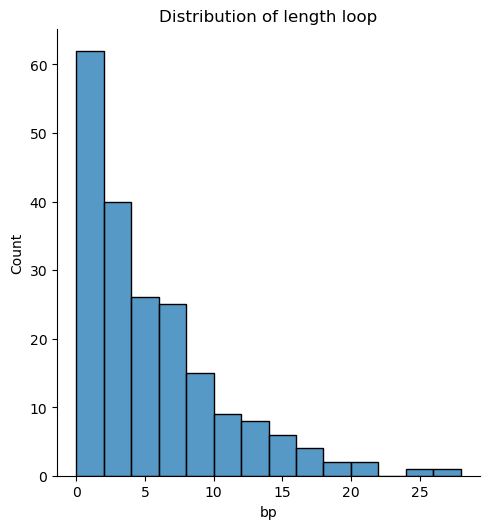

In [165]:
sns.displot(pd.concat([g4pqsconf['ll1'],g4pqsconf['ll2'],g4pqsconf['ll3']])) \
    .set(title='Distribution of length loop', xlabel='bp')

In [154]:
g4pqsconf['llall'] = g4pqsconf['ll1'] + g4pqsconf['ll2'] + g4pqsconf['ll3']

In [166]:
g4pqsconf['llall'].median()

14.0

In [167]:
g4pqsconf['llall'].describe()

count    67.000000
mean     15.089552
std       7.879262
min       3.000000
25%      10.000000
50%      14.000000
75%      21.000000
max      32.000000
Name: llall, dtype: float64

C:\Users\777\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\777\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


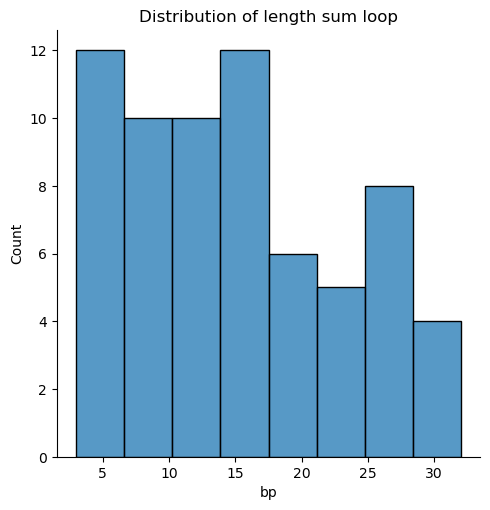

In [164]:
sns.displot(g4pqsconf['llall']).set(title='Distribution of length sum loop', xlabel='bp')

## NEW Add category to nucteotids

In [123]:
nuc_positions = []
for seq, start, G4_id in zip(g4pqsconf['sequence'], g4pqsconf['start'], g4pqsconf['G4_id']):
    for (i, j), (x, y) in zip(enumerate(seq, start=start), enumerate(seq)):
        row = [G4_id,x,i,j]
        nuc_positions.append(row)

In [124]:
nuc_positions = pd.DataFrame(nuc_positions, columns=['G4_id', 'pos_in_seq', 'pos_in_ref', 'nuc'])

In [125]:
nuc_positions

,G4_id,pos_in_seq,pos_in_ref,nuc
0,1,0,295,C
1,1,1,296,C
2,1,2,297,A
3,1,3,298,C
4,1,4,299,C
...,...,...,...,...
2418,67,23,16376,C
2419,67,24,16377,C
2420,67,25,16378,C
2421,67,26,16379,C


In [127]:
# sequence = '[CC(A)CC]AAA[CCCC]C[CCtC][CCCC]'  #for example
def categorize_sequence(sequence):  
    pattern = r'\[[A-Z]+\]|\([A-Z]+\)|\[[A-Z]+|[A-Z]+\]|[A-Z]+|[a-z]+'
    
    matches = re.findall(pattern, sequence)
    categories = []
    
    for match in matches:
        # print(match)
        if match.startswith('[') or match.endswith(']'):
            categories.extend(['Tetrad'] * len(match))
        elif match.startswith('(') and match.endswith(')'):
            categories.extend(['Bulges'] * len(match))
        elif match.isupper():
            categories.extend(['Loop'] * len(match))
        elif match.islower():
            categories.extend(['Mismatch'] * len(match))
    
    char_result = [char for char in sequence]

    return char_result, categories

In [127]:
# categorize_sequence('[CC(A)CC]AAA[CCCC]C[CCtC][CCCC]')

In [128]:
df_category = pd.DataFrame.from_records(g4pqsconf['pattern'].apply(categorize_sequence), 
                          columns=['char', 'category']) \
    .explode(['char', 'category']) \
    .reset_index(drop=True)

In [129]:
df_category

,char,category
0,[,Tetrad
1,C,Tetrad
2,C,Tetrad
3,(,Bulges
4,A,Bulges
...,...,...
3160,[,Tetrad
3161,C,Tetrad
3162,C,Tetrad
3163,C,Tetrad


In [129]:
df_category = df_category[~df_category['char'].isin(['[', ']', '(', ')'])].reset_index(drop=True)

In [130]:
# df_category = df_category.rename(columns={'char':'nuc'})
df_category['char'] = df_category['char'].str.upper()

In [131]:
df_category = nuc_positions.join(df_category).drop('char', axis=1)

In [132]:
df_category

,G4_id,pos_in_seq,pos_in_ref,nuc,category
0,1,0,295,C,Tetrad
1,1,1,296,C,Tetrad
2,1,2,297,A,Bulges
3,1,3,298,C,Tetrad
4,1,4,299,C,Tetrad
...,...,...,...,...,...
2418,67,23,16376,C,Tetrad
2419,67,24,16377,C,Tetrad
2420,67,25,16378,C,Tetrad
2421,67,26,16379,C,Tetrad


In [107]:
# df_category.to_csv('../data/processed/df_category_pqs.csv', index=False)

### Choose only loops from each G4

In [68]:
df_category = pd.read_csv('../data/processed/df_category_pqs.csv')

In [70]:
df_category[df_category['category'] == 'Loop']

,G4_id,pos_in_seq,pos_in_ref,nuc,category
5,1,5,300,A,Loop
6,1,6,301,A,Loop
7,1,7,302,A,Loop
12,1,12,307,C,Loop
25,2,4,357,A,Loop
...,...,...,...,...,...
2412,67,17,16370,G,Loop
2413,67,18,16371,A,Loop
2414,67,19,16372,T,Loop
2415,67,20,16373,G,Loop


In [89]:
data_loops = []
for G4_id in df_category[df_category['category'] == 'Loop']['G4_id'].unique():
    row = []
    positions = df_category[(df_category['category'] == 'Loop') & (df_category['G4_id'] == G4_id)]['pos_in_ref'].values.tolist()
    seq = ''.join(df_category[(df_category['category'] == 'Loop') & (df_category['G4_id'] == G4_id)]['nuc'].values)

    row.append(G4_id)
    row.append('loops')
    row.append(positions)
    row.append(seq)
    data_loops.append(row)

In [91]:
data_loops
data_loops = pd.DataFrame(data=data_loops, columns = ['G4_id', 'side', 'positions', 'sequence'])
nuc_count = data_loops['sequence'].apply(lambda x: Counter(x))
nuc_count = pd.DataFrame.from_records(nuc_count).sort_index(axis=1)
data_loops = data_loops.join(nuc_count).fillna(0)

In [92]:
data_loops

,G4_id,side,positions,sequence,A,C,G,T
0,1,loops,"[300, 301, 302, 307]",AAAC,3,1.0,0.0,0.0
1,2,loops,"[357, 358, 359, 360, 361, 372, 373, 374, 379, ...",AAAAATAAAG,8,0.0,1.0,1.0
2,3,loops,"[464, 470, 471, 472, 473, 474, 475, 476, 477, ...",AATACTACTAATCTCATCAATACAAG,12,6.0,1.0,7.0
3,4,loops,"[538, 539, 540, 545, 546, 547, 548, 549, 550, ...",ATAGAACCAACCAAAAAAGACA,14,5.0,2.0,1.0
4,5,loops,"[961, 966, 967, 968, 969, 970, 971, 972, 973, ...",TAATAAAGCTAAAACTTGAGTTGTAAAAAA,16,2.0,4.0,8.0
...,...,...,...,...,...,...,...,...
62,63,loops,"[15530, 15531, 15532, 15533, 15534, 15535, 155...",TTAAACATA,5,1.0,0.0,3.0
63,64,loops,"[15633, 15634, 15635, 15636, 15637, 15638, 156...",TATCCATTAGCAATAATAT,8,3.0,1.0,7.0
64,65,loops,"[16170, 16171, 16172, 16177, 16178, 16179, 161...",AATATCAAAACT,7,2.0,0.0,3.0
65,66,loops,"[16263, 16264, 16265, 16269, 16270, 16271, 162...",TCAACTAGGATACCAACAAACCTAA,12,7.0,2.0,4.0


In [15]:
data_loops = pd.read_csv('../data/processed/data_loops_pqs.csv')

In [17]:
data_loops['loop_len'] = data_loops['sequence'].apply(lambda x: len(x))

In [18]:
data_loops

,G4_id,side,positions,sequence,A,C,G,T,loop_len
0,1,loops,"[300, 301, 302, 307]",AAAC,3,1.0,0.0,0.0,4
1,2,loops,"[357, 358, 359, 360, 361, 372, 373, 374, 379, ...",AAAAATAAAG,8,0.0,1.0,1.0,10
2,3,loops,"[464, 470, 471, 472, 473, 474, 475, 476, 477, ...",AATACTACTAATCTCATCAATACAAG,12,6.0,1.0,7.0,26
3,4,loops,"[538, 539, 540, 545, 546, 547, 548, 549, 550, ...",ATAGAACCAACCAAAAAAGACA,14,5.0,2.0,1.0,22
4,5,loops,"[961, 966, 967, 968, 969, 970, 971, 972, 973, ...",TAATAAAGCTAAAACTTGAGTTGTAAAAAA,16,2.0,4.0,8.0,30
...,...,...,...,...,...,...,...,...,...
62,63,loops,"[15530, 15531, 15532, 15533, 15534, 15535, 155...",TTAAACATA,5,1.0,0.0,3.0,9
63,64,loops,"[15633, 15634, 15635, 15636, 15637, 15638, 156...",TATCCATTAGCAATAATAT,8,3.0,1.0,7.0,19
64,65,loops,"[16170, 16171, 16172, 16177, 16178, 16179, 161...",AATATCAAAACT,7,2.0,0.0,3.0,12
65,66,loops,"[16263, 16264, 16265, 16269, 16270, 16271, 162...",TCAACTAGGATACCAACAAACCTAA,12,7.0,2.0,4.0,25


In [20]:
# data_loops.to_csv('../data/processed/data_loops_pqs.csv', index=False)

### Choose tetrad for each G4

In [17]:
df_category = pd.read_csv('../data/processed/df_category_pqs.csv')

In [21]:
df_category['category'].unique()

array(['Tetrad', 'Bulges', 'Loop', 'Mismatch'], dtype=object)

In [27]:
df_category[df_category['category'].isin(['Tetrad', 'Mismatch'])]

,G4_id,pos_in_seq,pos_in_ref,nuc,category
0,1,0,295,C,Tetrad
1,1,1,296,C,Tetrad
3,1,3,298,C,Tetrad
4,1,4,299,C,Tetrad
8,1,8,303,C,Tetrad
...,...,...,...,...,...
2418,67,23,16376,C,Tetrad
2419,67,24,16377,C,Tetrad
2420,67,25,16378,C,Tetrad
2421,67,26,16379,C,Tetrad


In [28]:
data_tetrads = []
for G4_id in df_category[df_category['category'].isin(['Tetrad', 'Mismatch'])]['G4_id'].unique():
    row = []
    positions = df_category[(df_category['category'].isin(['Tetrad', 'Mismatch'])) & (df_category['G4_id'] == G4_id)]['pos_in_ref'].values.tolist()
    seq = ''.join(df_category[(df_category['category'].isin(['Tetrad', 'Mismatch'])) & (df_category['G4_id'] == G4_id)]['nuc'].values)

    row.append(G4_id)
    row.append('tetrads')
    row.append(positions)
    row.append(seq)
    data_tetrads.append(row)

In [29]:
data_tetrads = pd.DataFrame(data=data_tetrads, columns = ['G4_id', 'side', 'positions', 'sequence'])
nuc_count = data_tetrads['sequence'].apply(lambda x: Counter(x))
nuc_count = pd.DataFrame.from_records(nuc_count).sort_index(axis=1)
data_tetrads = data_tetrads.join(nuc_count).fillna(0)

In [34]:
#Add G column
data_tetrads['G'] = 0

In [35]:
data_tetrads

,G4_id,side,positions,sequence,A,C,T,G
0,1,tetrads,"[295, 296, 298, 299, 303, 304, 305, 306, 308, ...",CCCCCCCCCCTCCCCC,0.0,15,1.0,0
1,2,tetrads,"[353, 354, 355, 356, 362, 369, 370, 371, 375, ...",CCCCCCCCCACCCCCC,1.0,15,0.0,0
2,3,tetrads,"[458, 459, 461, 462, 463, 465, 466, 467, 468, ...",CCCCCCTCCCCCCCCCCCCC,0.0,19,1.0,0
3,4,tetrads,"[534, 535, 536, 537, 541, 542, 543, 544, 557, ...",CCCCCCCCCCCCCCCC,0.0,16,0.0,0
4,5,tetrads,"[957, 958, 959, 960, 962, 963, 964, 965, 981, ...",CCCCCCCCCACCCTCC,1.0,14,1.0,0
...,...,...,...,...,...,...,...,...
62,63,tetrads,"[15526, 15527, 15528, 15529, 15537, 15538, 155...",CCCCCCCCCCCCCCCC,0.0,16,0.0,0
63,64,tetrads,"[15624, 15625, 15626, 15632, 15640, 15641, 156...",CCCCCCCCCCCCCCCC,0.0,16,0.0,0
64,65,tetrads,"[16159, 16167, 16168, 16169, 16173, 16174, 161...",CCCCCCACCCCCCCCC,1.0,15,0.0,0
65,66,tetrads,"[16260, 16261, 16262, 16266, 16267, 16268, 162...",CCCCCCCCCCCC,0.0,12,0.0,0


In [37]:
# data_tetrads.to_csv('../data/processed/data_tetrads_pqs.csv', index=False)

## Step 2
### Add columns: 
- 'bp_untill_next_G4' and 'bp_untill_previous_G4'
- 'up_win' and 'down_win 

### old

In [24]:
refG4 = pd.read_excel('../data/processed/refG4.xlsx')

In [25]:
g4conf = refG4[refG4['confirmed'] == 1]
g4conf = g4conf.reset_index(drop=True)

In [26]:
g4conf.head()

,seqnames,start,end,width,strand,score,max_score,threshold,window,sequence,confirmed,G4,note,start-100bp,end+100bp
0,"NC_012920.1 Homo sapiens mitochondrion, comple...",285,332,48,-,-1.25,-2.24,1,25,CAAAAAATTTCCACCAAACCCCCCCTCCCCCGCTTCTGGCCACAGCAC,1,G4,more than africa,185,432
1,"NC_012920.1 Homo sapiens mitochondrion, comple...",348,378,31,-,-1.10,-1.16,1,25,CCAAACCCCAAAAACAAAGAACCCTAACACC,1,UG4,less than africa,248,478
2,"NC_012920.1 Homo sapiens mitochondrion, comple...",418,592,175,-,-1.15,-1.88,1,25,CACTTTTAACAGTCACCCCCCAACTAACACATTATTTTCCCCTCCC...,1,G4,5 overlapping g4 in africa,318,692
3,"NC_012920.1 Homo sapiens mitochondrion, comple...",785,808,24,-,-1.21,-1.16,1,25,CGCTTAGCCTAGCCACACCCCCAC,1,G4,NaN,685,908
4,"NC_012920.1 Homo sapiens mitochondrion, comple...",954,984,31,-,-1.39,-1.48,1,25,CACCCCCTCCCCAATAAAGCTAAAACTCACC,1,G4,NaN,854,1084


In [27]:
g4conf = add_columns(g4conf)

In [28]:
# g4conf.to_csv('../data/processed/g4conf.csv', index=False)

### NEW pqsfinder

In [8]:
g4pqsconf.head()

,start,end,score,pattern,G4_id,sequence,bp_untill_next_G4,bp_untill_previous_G4,up_win,down_win
0,295,315,64,[CC(A)CC]AAA[CCCC]C[CCtC][CCCC],1,CCACCAAACCCCCCCTCCCCC,38,484,195,353
1,353,387,33,[CCCC]AAAAA[C(AAAGAA)CCC]TAA[CaCC]AG[CC(TAA)CC],2,CCCCAAAAACAAAGAACCCTAACACCAGCCTAACC,71,38,315,458
2,458,506,55,[CC(T)CCC]A[CtCCC]ATACTACTAATCTCATCAATACAA[CCC...,3,CCTCCCACTCCCATACTACTAATCTCATCAATACAACCCCCGCCCATCC,28,71,387,534
3,534,571,88,[CCCC]ATA[CCCC]GAACCAACCAAA[CCCC]AAAGACA[CCCC],4,CCCCATACCCCGAACCAACCAAACCCCAAAGACACCCC,386,28,506,671
4,957,1002,22,[CCCC]T[CCCC]AATAAAGCTAAAACT[CaCC]TGAGTTGTAAAA...,5,CCCCTCCCCAATAAAGCTAAAACTCACCTGAGTTGTAAAAAACTCC,680,386,857,1102


In [19]:
g4pqsconf = add_columns(g4pqsconf)

In [20]:
g4pqsconf.head()

,start,end,score,pattern,G4_id,sequence,bp_untill_next_G4,bp_untill_previous_G4,up_win,down_win
0,295,315,64,[CC(A)CC]AAA[CCCC]C[CCtC][CCCC],1,CCACCAAACCCCCCCTCCCCC,38,484,195,353
1,353,387,33,[CCCC]AAAAA[C(AAAGAA)CCC]TAA[CaCC]AG[CC(TAA)CC],2,CCCCAAAAACAAAGAACCCTAACACCAGCCTAACC,71,38,315,458
2,458,506,55,[CC(T)CCC]A[CtCCC]ATACTACTAATCTCATCAATACAA[CCC...,3,CCTCCCACTCCCATACTACTAATCTCATCAATACAACCCCCGCCCATCC,28,71,387,534
3,534,571,88,[CCCC]ATA[CCCC]GAACCAACCAAA[CCCC]AAAGACA[CCCC],4,CCCCATACCCCGAACCAACCAAACCCCAAAGACACCCC,386,28,506,671
4,957,1002,22,[CCCC]T[CCCC]AATAAAGCTAAAACT[CaCC]TGAGTTGTAAAA...,5,CCCCTCCCCAATAAAGCTAAAACTCACCTGAGTTGTAAAAAACTCC,680,386,857,1102


In [40]:
# g4pqsconf.to_csv('../data/processed/g4pqsconf.csv', index=False)

#### **Add +-15bp**

In [21]:
g4pqsconf

,start,end,score,pattern,G4_id,sequence,bp_untill_next_G4,bp_untill_previous_G4,up_win,down_win
0,295,315,64,[CC(A)CC]AAA[CCCC]C[CCtC][CCCC],1,CCACCAAACCCCCCCTCCCCC,38,484,195,353
1,353,387,33,[CCCC]AAAAA[C(AAAGAA)CCC]TAA[CaCC]AG[CC(TAA)CC],2,CCCCAAAAACAAAGAACCCTAACACCAGCCTAACC,71,38,315,458
2,458,506,55,[CC(T)CCC]A[CtCCC]ATACTACTAATCTCATCAATACAA[CCC...,3,CCTCCCACTCCCATACTACTAATCTCATCAATACAACCCCCGCCCATCC,28,71,387,534
3,534,571,88,[CCCC]ATA[CCCC]GAACCAACCAAA[CCCC]AAAGACA[CCCC],4,CCCCATACCCCGAACCAACCAAACCCCAAAGACACCCC,386,28,506,671
4,957,1002,22,[CCCC]T[CCCC]AATAAAGCTAAAACT[CaCC]TGAGTTGTAAAA...,5,CCCCTCCCCAATAAAGCTAAAACTCACCTGAGTTGTAAAAAACTCC,680,386,857,1102
...,...,...,...,...,...,...,...,...,...,...
62,15526,15556,83,[CCCC]TTAAACA[CCCC]T[CCCC]A[C(ATCAAG)CCC],63,CCCCTTAAACACCCCTCCCCACATCAAGCCC,68,8,15518,15624
63,15624,15668,29,[CCC(TATTA)C]TATCCAT[CC(TCAT)CC]TAGCAATAAT[CCC...,64,CCCTATTACTATCCATCCTCATCCTAGCAATAATCCCCATCCTCC,491,68,15556,15768
64,16159,16193,51,[C(ATAAAAA)CCC]AAT[CCaC]ATCAAAAC[CCCC]T[CCCC],65,CATAAAAACCCAATCCACATCAAAACCCCCTCCCC,67,491,16059,16260
65,16260,16296,44,[CCC]TCA[CCC]ACTAGGATACCAACAAACCTA[CCC]A[CCC],66,CCCTCACCCACTAGGATACCAACAAACCTACCCACCC,57,67,16193,16353


In [22]:
g4pqsconf = add_columns_15(g4pqsconf).fillna(0)

In [23]:
g4pqsconf

,start,end,score,pattern,G4_id,sequence,bp_untill_next_G4,bp_untill_previous_G4,up_win,down_win,15_up,15_down,30_up,30_down,45_up,45_down
0,295,315,64,[CC(A)CC]AAA[CCCC]C[CCtC][CCCC],1,CCACCAAACCCCCCCTCCCCC,38,484,195,353,280.0,330.0,265.0,345.0,250.0,0.0
1,353,387,33,[CCCC]AAAAA[C(AAAGAA)CCC]TAA[CaCC]AG[CC(TAA)CC],2,CCCCAAAAACAAAGAACCCTAACACCAGCCTAACC,71,38,315,458,338.0,402.0,323.0,417.0,0.0,432.0
2,458,506,55,[CC(T)CCC]A[CtCCC]ATACTACTAATCTCATCAATACAA[CCC...,3,CCTCCCACTCCCATACTACTAATCTCATCAATACAACCCCCGCCCATCC,28,71,387,534,443.0,521.0,428.0,0.0,413.0,0.0
3,534,571,88,[CCCC]ATA[CCCC]GAACCAACCAAA[CCCC]AAAGACA[CCCC],4,CCCCATACCCCGAACCAACCAAACCCCAAAGACACCCC,386,28,506,671,519.0,586.0,0.0,601.0,0.0,616.0
4,957,1002,22,[CCCC]T[CCCC]AATAAAGCTAAAACT[CaCC]TGAGTTGTAAAA...,5,CCCCTCCCCAATAAAGCTAAAACTCACCTGAGTTGTAAAAAACTCC,680,386,857,1102,942.0,1017.0,927.0,1032.0,912.0,1047.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,15526,15556,83,[CCCC]TTAAACA[CCCC]T[CCCC]A[C(ATCAAG)CCC],63,CCCCTTAAACACCCCTCCCCACATCAAGCCC,68,8,15518,15624,0.0,15571.0,0.0,15586.0,0.0,15601.0
63,15624,15668,29,[CCC(TATTA)C]TATCCAT[CC(TCAT)CC]TAGCAATAAT[CCC...,64,CCCTATTACTATCCATCCTCATCCTAGCAATAATCCCCATCCTCC,491,68,15556,15768,15609.0,15683.0,15594.0,15698.0,15579.0,15713.0
64,16159,16193,51,[C(ATAAAAA)CCC]AAT[CCaC]ATCAAAAC[CCCC]T[CCCC],65,CATAAAAACCCAATCCACATCAAAACCCCCTCCCC,67,491,16059,16260,16144.0,16208.0,16129.0,16223.0,16114.0,16238.0
65,16260,16296,44,[CCC]TCA[CCC]ACTAGGATACCAACAAACCTA[CCC]A[CCC],66,CCCTCACCCACTAGGATACCAACAAACCTACCCACCC,57,67,16193,16353,16245.0,16311.0,16230.0,16326.0,16215.0,16341.0


In [21]:
def make_15_col(df:pd.DataFrame, column_15:str, start_or_end:str, up=True):
    data_up = []
    for up_15, start, G4_id in zip(df[column_15], df[start_or_end], df['G4_id']):
        if up_15 > 0:
            row = []
            seq = ''
            if up == True:
                window = [*range(int(up_15), int(start))]
            elif up == False:
                window = [*range(int(start), int(up_15))]
            
            for pos in window:
                if pos != 3107:
                    seq += str(ref_annot[ref_annot['Pos'] == pos].Nuc.values[0])
                else:
                    seq += ''
            row.append(G4_id)
            row.append(column_15)
            if up == True:
                row.append(int(up_15))
                row.append(int(start))
            elif up == False:    
                row.append(int(start))
                row.append(int(up_15))
            row.append(seq)
    
            data_up.append(row)
        else:
            continue
    return data_up

In [63]:
data_15_col = make_15_col(g4pqsconf, '15_up', 'start', up=True) + \
make_15_col(g4pqsconf, '30_up', '15_up', up=True) + \
make_15_col(g4pqsconf, '45_up', '30_up', up=True) + \
make_15_col(g4pqsconf, '15_down', 'end', up=False) + \
make_15_col(g4pqsconf, '30_down', '15_down', up=False) + \
make_15_col(g4pqsconf, '45_down', '30_down', up=False)

In [64]:
data_15_col = pd.DataFrame(data=data_15_col, columns = ['G4_id', 'side', 'window_start', 'window_end', 'sequence'])
nuc_count_15 = data_15_col['sequence'].apply(lambda x: Counter(x))
nuc_count_15 = pd.DataFrame.from_records(nuc_count_15).sort_index(axis=1)
data_15_col = data_15_col.join(nuc_count_15).fillna(0)

In [65]:
data_15_col

,G4_id,side,window_start,window_end,sequence,A,C,G,T
0,1,15_up,280,295,CATAACAAAAAATTT,9.0,2.0,0.0,4
1,2,15_up,338,353,CACATCTCTGCCAAA,5.0,6.0,1.0,3
2,3,15_up,443,458,AACACATTATTTTCC,5.0,4.0,0.0,6
3,4,15_up,519,534,ACACACCGCTGCTAA,5.0,6.0,2.0,2
4,5,15_up,942,957,AGTGTTTTAGATCAC,4.0,2.0,3.0,6
...,...,...,...,...,...,...,...,...,...
353,63,45_down,15586,15601,TCTCCGATCCGTCCC,1.0,8.0,2.0,4
354,64,45_down,15698,15713,CGCCCACTAAGCCAA,5.0,7.0,2.0,1
355,65,45_down,16223,16238,CTCAACTATCACACA,6.0,6.0,0.0,3
356,66,45_down,16326,16341,ACCGTACATAGCACA,6.0,5.0,2.0,2


In [67]:
# data_15_col.to_csv('../data/processed/data_15_col_pqs.csv', index=False)

In [2]:
data_15_col = pd.read_csv('../data/processed/data_15_col_pqs.csv')

In [5]:
data_15_col[data_15_col['G4_id'] == 2]

,G4_id,side,window_start,window_end,sequence,A,C,G,T
1,2,15_up,338,353,CACATCTCTGCCAAA,5.0,6.0,1.0,3
66,2,30_up,323,338,GCCACAGCACTTAAA,6.0,5.0,2.0,2
180,2,15_down,387,402,CAGATTTCAAATTTT,5.0,2.0,1.0,7
245,2,30_down,402,417,ATCTTTTGGCGGTAT,2.0,2.0,4.0,7
303,2,45_down,417,432,GCACTTTTAACAGTC,4.0,4.0,2.0,5


### Make 100bp columns

In [28]:
g4pqsconf = add_columns_50(g4pqsconf).fillna(0)

In [29]:
g4pqsconf

,start,end,score,pattern,G4_id,sequence,bp_untill_next_G4,bp_untill_previous_G4,up_win,down_win,50_up,50_down,100_up,100_down
0,295,315,64,[CC(A)CC]AAA[CCCC]C[CCtC][CCCC],1,CCACCAAACCCCCCCTCCCCC,38,484,195,353,245.0,0.0,195.0,0.0
1,353,387,33,[CCCC]AAAAA[C(AAAGAA)CCC]TAA[CaCC]AG[CC(TAA)CC],2,CCCCAAAAACAAAGAACCCTAACACCAGCCTAACC,71,38,315,458,0.0,437.0,0.0,0.0
2,458,506,55,[CC(T)CCC]A[CtCCC]ATACTACTAATCTCATCAATACAA[CCC...,3,CCTCCCACTCCCATACTACTAATCTCATCAATACAACCCCCGCCCATCC,28,71,387,534,408.0,0.0,0.0,0.0
3,534,571,88,[CCCC]ATA[CCCC]GAACCAACCAAA[CCCC]AAAGACA[CCCC],4,CCCCATACCCCGAACCAACCAAACCCCAAAGACACCCC,386,28,506,671,0.0,621.0,0.0,671.0
4,957,1002,22,[CCCC]T[CCCC]AATAAAGCTAAAACT[CaCC]TGAGTTGTAAAA...,5,CCCCTCCCCAATAAAGCTAAAACTCACCTGAGTTGTAAAAAACTCC,680,386,857,1102,907.0,1052.0,857.0,1102.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,15526,15556,83,[CCCC]TTAAACA[CCCC]T[CCCC]A[C(ATCAAG)CCC],63,CCCCTTAAACACCCCTCCCCACATCAAGCCC,68,8,15518,15624,0.0,15606.0,0.0,0.0
63,15624,15668,29,[CCC(TATTA)C]TATCCAT[CC(TCAT)CC]TAGCAATAAT[CCC...,64,CCCTATTACTATCCATCCTCATCCTAGCAATAATCCCCATCCTCC,491,68,15556,15768,15574.0,15718.0,0.0,15768.0
64,16159,16193,51,[C(ATAAAAA)CCC]AAT[CCaC]ATCAAAAC[CCCC]T[CCCC],65,CATAAAAACCCAATCCACATCAAAACCCCCTCCCC,67,491,16059,16260,16109.0,16243.0,16059.0,0.0
65,16260,16296,44,[CCC]TCA[CCC]ACTAGGATACCAACAAACCTA[CCC]A[CCC],66,CCCTCACCCACTAGGATACCAACAAACCTACCCACCC,57,67,16193,16353,16210.0,16346.0,0.0,0.0


In [30]:
def make_15_col(df:pd.DataFrame, column_15:str, start_or_end:str, up=True):
    data_up = []
    for up_15, start, G4_id in zip(df[column_15], df[start_or_end], df['G4_id']):
        if up_15 > 0:
            row = []
            seq = ''
            if up == True:
                window = [*range(int(up_15), int(start))]
            elif up == False:
                window = [*range(int(start), int(up_15))]
            
            for pos in window:
                if pos != 3107:
                    seq += str(ref_annot[ref_annot['Pos'] == pos].Nuc.values[0])
                else:
                    seq += ''
            row.append(G4_id)
            row.append(column_15)
            if up == True:
                row.append(int(up_15))
                row.append(int(start))
            elif up == False:    
                row.append(int(start))
                row.append(int(up_15))
            row.append(seq)
    
            data_up.append(row)
        else:
            continue
    return data_up

In [44]:
data_100_col = make_15_col(g4pqsconf, '50_up', 'start', up=True) + \
make_15_col(g4pqsconf, '100_up', '50_up', up=True) + \
make_15_col(g4pqsconf, '50_down', 'end', up=False) + \
make_15_col(g4pqsconf, '100_down', '50_down', up=False)

In [45]:
data_100_col = pd.DataFrame(data=data_100_col, columns = ['G4_id', 'side', 'window_start', 'window_end', 'sequence'])
nuc_count_100 = data_100_col['sequence'].apply(lambda x: Counter(x))
nuc_count_100 = pd.DataFrame.from_records(nuc_count_100).sort_index(axis=1)
data_100_col = data_100_col.join(nuc_count_100).fillna(0)

In [46]:
data_100_col

,G4_id,side,window_start,window_end,sequence,A,C,G,T
0,1,50_up,245,295,TTGAATGTCTGCACAGCCACTTTCCACACAGACATCATAACAAAAA...,19,13,5.0,13
1,3,50_up,408,458,TGGCGGTATGCACTTTTAACAGTCACCCCCCAACTAACACATTATT...,13,16,6.0,15
2,5,50_up,907,957,ACGATTAACCCAAGTCAATAGAAGCCGGCGTAAAGAGTGTTTTAGA...,18,10,11.0,11
3,6,50_up,1632,1682,TTACACTTAGGAGATTTCAACTTAACTTGACCGCTCTGAGCTAAAC...,15,12,8.0,15
4,7,50_up,2007,2057,TGGTGATAGCTGGTTGTCCAAGATAGAATCTTAGTTCAACTTTAAA...,14,6,11.0,19
...,...,...,...,...,...,...,...,...,...
179,53,100_down,14187,14237,CAACAAACAATGTTCAACCAGTAACTACTACTAATCAACGCCCATA...,22,15,3.0,10
180,59,100_down,14694,14744,CCACGACCAATGATATGAAAAACCATCGTTGTATTTCAACTACAAG...,21,12,6.0,11
181,60,100_down,14867,14917,CTGATCCTCCAAATCACCACAGGACTATTCCTAGCCATGCACTACT...,14,20,5.0,11
182,64,100_down,15718,15768,TTATTGACTCCTAGCCGCAGACCTCCTCATTCTAACCTGAATCGGA...,12,16,9.0,13


In [48]:
# data_100_col.to_csv('../data/processed/data_100_col_pqs.csv', index=False)

### Len(interval) == len(loops)

In [82]:
g4pqsconf.head()

,start,end,score,pattern,G4_id,sequence,bp_untill_next_G4,bp_untill_previous_G4,up_win,down_win,loop_len,n_up,n_down
0,295,315,64,[CC(A)CC]AAA[CCCC]C[CCtC][CCCC],1,CCACCAAACCCCCCCTCCCCC,38,484,195,353,4,291.0,319.0
1,353,387,33,[CCCC]AAAAA[C(AAAGAA)CCC]TAA[CaCC]AG[CC(TAA)CC],2,CCCCAAAAACAAAGAACCCTAACACCAGCCTAACC,71,38,315,458,10,343.0,397.0
2,458,506,55,[CC(T)CCC]A[CtCCC]ATACTACTAATCTCATCAATACAA[CCC...,3,CCTCCCACTCCCATACTACTAATCTCATCAATACAACCCCCGCCCATCC,28,71,387,534,26,432.0,532.0
3,534,571,88,[CCCC]ATA[CCCC]GAACCAACCAAA[CCCC]AAAGACA[CCCC],4,CCCCATACCCCGAACCAACCAAACCCCAAAGACACCCC,386,28,506,671,22,512.0,593.0
4,957,1002,22,[CCCC]T[CCCC]AATAAAGCTAAAACT[CaCC]TGAGTTGTAAAA...,5,CCCCTCCCCAATAAAGCTAAAACTCACCTGAGTTGTAAAAAACTCC,680,386,857,1102,30,927.0,1032.0


In [23]:
g4pqsconf['loop_len'] = data_loops['loop_len']

In [81]:
g4pqsconf.head()

,start,end,score,pattern,G4_id,sequence,bp_untill_next_G4,bp_untill_previous_G4,up_win,down_win,loop_len,n_up,n_down
0,295,315,64,[CC(A)CC]AAA[CCCC]C[CCtC][CCCC],1,CCACCAAACCCCCCCTCCCCC,38,484,195,353,4,291.0,319.0
1,353,387,33,[CCCC]AAAAA[C(AAAGAA)CCC]TAA[CaCC]AG[CC(TAA)CC],2,CCCCAAAAACAAAGAACCCTAACACCAGCCTAACC,71,38,315,458,10,343.0,397.0
2,458,506,55,[CC(T)CCC]A[CtCCC]ATACTACTAATCTCATCAATACAA[CCC...,3,CCTCCCACTCCCATACTACTAATCTCATCAATACAACCCCCGCCCATCC,28,71,387,534,26,432.0,532.0
3,534,571,88,[CCCC]ATA[CCCC]GAACCAACCAAA[CCCC]AAAGACA[CCCC],4,CCCCATACCCCGAACCAACCAAACCCCAAAGACACCCC,386,28,506,671,22,512.0,593.0
4,957,1002,22,[CCCC]T[CCCC]AATAAAGCTAAAACT[CaCC]TGAGTTGTAAAA...,5,CCCCTCCCCAATAAAGCTAAAACTCACCTGAGTTGTAAAAAACTCC,680,386,857,1102,30,927.0,1032.0


In [66]:
g4pqsconf['n_up'] = g4pqsconf[g4pqsconf['bp_untill_previous_G4'] >= g4pqsconf['loop_len']]['start']-g4pqsconf['loop_len']

In [68]:
g4pqsconf['n_down'] = g4pqsconf[g4pqsconf['bp_untill_next_G4'] >= g4pqsconf['loop_len']]['end']+g4pqsconf['loop_len']

In [79]:
g4pqsconf.head()

,start,end,score,pattern,G4_id,sequence,bp_untill_next_G4,bp_untill_previous_G4,up_win,down_win,loop_len,n_up,n_down
0,295,315,64,[CC(A)CC]AAA[CCCC]C[CCtC][CCCC],1,CCACCAAACCCCCCCTCCCCC,38,484,195,353,4,291.0,319.0
1,353,387,33,[CCCC]AAAAA[C(AAAGAA)CCC]TAA[CaCC]AG[CC(TAA)CC],2,CCCCAAAAACAAAGAACCCTAACACCAGCCTAACC,71,38,315,458,10,343.0,397.0
2,458,506,55,[CC(T)CCC]A[CtCCC]ATACTACTAATCTCATCAATACAA[CCC...,3,CCTCCCACTCCCATACTACTAATCTCATCAATACAACCCCCGCCCATCC,28,71,387,534,26,432.0,532.0
3,534,571,88,[CCCC]ATA[CCCC]GAACCAACCAAA[CCCC]AAAGACA[CCCC],4,CCCCATACCCCGAACCAACCAAACCCCAAAGACACCCC,386,28,506,671,22,512.0,593.0
4,957,1002,22,[CCCC]T[CCCC]AATAAAGCTAAAACT[CaCC]TGAGTTGTAAAA...,5,CCCCTCCCCAATAAAGCTAAAACTCACCTGAGTTGTAAAAAACTCC,680,386,857,1102,30,927.0,1032.0


In [74]:
data_n_col = make_15_col(g4pqsconf, 'n_up', 'start', up=True) + make_15_col(g4pqsconf, 'n_down', 'end', up=False)

In [75]:
data_n_col = pd.DataFrame(data=data_n_col, columns = ['G4_id', 'side', 'window_start', 'window_end', 'sequence'])
nuc_count_n = data_n_col['sequence'].apply(lambda x: Counter(x))
nuc_count_n = pd.DataFrame.from_records(nuc_count_n).sort_index(axis=1)
data_n_col = data_n_col.join(nuc_count_n).fillna(0)

In [80]:
data_n_col.head()

,G4_id,side,window_start,window_end,sequence,A,C,G,T
0,1,n_up,291,295,ATTT,1.0,0.0,0.0,3.0
1,2,n_up,343,353,CTCTGCCAAA,3.0,4.0,1.0,2.0
2,3,n_up,432,458,ACCCCCCAACTAACACATTATTTTCC,8.0,11.0,0.0,7.0
3,4,n_up,512,534,AGCACACACACACCGCTGCTAA,8.0,9.0,3.0,2.0
4,5,n_up,927,957,GAAGCCGGCGTAAAGAGTGTTTTAGATCAC,9.0,5.0,9.0,7.0


In [78]:
# data_n_col.to_csv('../data/processed/data_n_col_pqs.csv', index=False)

### Interval +50bp 

In [22]:
g4pqsconf

,start,end,score,pattern,G4_id,sequence,bp_untill_next_G4,bp_untill_previous_G4,up_win,down_win
0,295,315,64,[CC(A)CC]AAA[CCCC]C[CCtC][CCCC],1,CCACCAAACCCCCCCTCCCCC,38,484,195,353
1,353,387,33,[CCCC]AAAAA[C(AAAGAA)CCC]TAA[CaCC]AG[CC(TAA)CC],2,CCCCAAAAACAAAGAACCCTAACACCAGCCTAACC,71,38,315,458
2,458,506,55,[CC(T)CCC]A[CtCCC]ATACTACTAATCTCATCAATACAA[CCC...,3,CCTCCCACTCCCATACTACTAATCTCATCAATACAACCCCCGCCCATCC,28,71,387,534
3,534,571,88,[CCCC]ATA[CCCC]GAACCAACCAAA[CCCC]AAAGACA[CCCC],4,CCCCATACCCCGAACCAACCAAACCCCAAAGACACCCC,386,28,506,671
4,957,1002,22,[CCCC]T[CCCC]AATAAAGCTAAAACT[CaCC]TGAGTTGTAAAA...,5,CCCCTCCCCAATAAAGCTAAAACTCACCTGAGTTGTAAAAAACTCC,680,386,857,1102
...,...,...,...,...,...,...,...,...,...,...
62,15526,15556,83,[CCCC]TTAAACA[CCCC]T[CCCC]A[C(ATCAAG)CCC],63,CCCCTTAAACACCCCTCCCCACATCAAGCCC,68,8,15518,15624
63,15624,15668,29,[CCC(TATTA)C]TATCCAT[CC(TCAT)CC]TAGCAATAAT[CCC...,64,CCCTATTACTATCCATCCTCATCCTAGCAATAATCCCCATCCTCC,491,68,15556,15768
64,16159,16193,51,[C(ATAAAAA)CCC]AAT[CCaC]ATCAAAAC[CCCC]T[CCCC],65,CATAAAAACCCAATCCACATCAAAACCCCCTCCCC,67,491,16059,16260
65,16260,16296,44,[CCC]TCA[CCC]ACTAGGATACCAACAAACCTA[CCC]A[CCC],66,CCCTCACCCACTAGGATACCAACAAACCTACCCACCC,57,67,16193,16353


In [37]:
g4pqsconf['50_up'] = pd.concat([g4pqsconf[g4pqsconf['bp_untill_previous_G4'] < 50][['bp_untill_previous_G4', 'start']]\
                                  .diff(axis=1)['bp_untill_previous_G4'],\
                                 g4pqsconf[g4pqsconf['bp_untill_previous_G4'] >= 50]['start']-50])
    
g4pqsconf['50_down'] = pd.concat([g4pqsconf[g4pqsconf['bp_untill_next_G4'] < 50][['end', 'bp_untill_next_G4']]\
                                        .diff(axis=1)['end'], \
                                   g4pqsconf[g4pqsconf['bp_untill_next_G4'] >= 50]['end']+50])

In [38]:
g4pqsconf = g4pqsconf.fillna(0)

In [39]:
g4pqsconf[(g4pqsconf['50_up'] > 0) & (g4pqsconf['50_down'] > 0)]['G4_id'].count()

44

In [40]:
data_50_col = make_15_col(g4pqsconf, '50_up', 'start', up=True) + make_15_col(g4pqsconf, '50_down', 'end', up=False)

In [41]:
data_50_col = pd.DataFrame(data=data_50_col, columns = ['G4_id', 'side', 'window_start', 'window_end', 'sequence'])
nuc_count_50 = data_50_col['sequence'].apply(lambda x: Counter(x))
nuc_count_50 = pd.DataFrame.from_records(nuc_count_50).sort_index(axis=1)
data_50_col = data_50_col.join(nuc_count_50).fillna(0)

In [43]:
# data_50_col.to_csv('../data/processed/data_50_col_pqs.csv', index=False)

## Step 3  
make windows for sliding window around G4 (make df_win)

### OLD  

New interval size:
- Take all confirmed G4   
- **Dont sort G4 by size between G4 >= 50 bp**  
- Obtain different interval size (0-100bp) between G4  

In [19]:
# G4_id = 38 hasnt downstream windows
# G4_id = 39 hasnt upsteram windows

In [87]:
# g4conf[(g4conf['G4_id'] == 38) | (g4conf['G4_id'] == 39)]

In [37]:
df_win = make_win_df(make_win_up(g4conf), make_win_down(g4conf))
df_win.head()

,G4_id,side,number_of_win,window_start,window_end,sequence,A,C,G,T
0,1,up,91,185,194,GCGAACATAC,4.0,3.0,2.0,1.0
1,1,up,90,186,195,CGAACATACT,4.0,3.0,1.0,2.0
2,1,up,89,187,196,GAACATACTT,4.0,2.0,1.0,3.0
3,1,up,88,188,197,AACATACTTA,5.0,2.0,0.0,3.0
4,1,up,87,189,198,ACATACTTAC,4.0,3.0,0.0,3.0


In [28]:
# df_win.to_csv('../data/processed/df_win.csv', index=False)

### NEW pqs

In [36]:
df_win_pqs = make_win_df(make_win_up(g4pqsconf), make_win_down(g4pqsconf))

In [37]:
df_win_pqs.head()

,G4_id,side,number_of_win,window_start,window_end,sequence,A,C,G,T
0,1,up,91,195,204,TTACTAAAGT,4.0,1.0,1.0,4.0
1,1,up,90,196,205,TACTAAAGTG,4.0,1.0,2.0,3.0
2,1,up,89,197,206,ACTAAAGTGT,4.0,1.0,2.0,3.0
3,1,up,88,198,207,CTAAAGTGTG,3.0,1.0,3.0,3.0
4,1,up,87,199,208,TAAAGTGTGT,3.0,0.0,3.0,4.0


In [43]:
# df_win_pqs.to_csv('../data/processed/df_win_pqs.csv', index=False)

# Data preparation around G4 for Cancer 

### Observed mutations Cancer dataset:

df_win_cancer - observed mutations from Cancer dataset with nucleotide frequencies from df_win
  
  Yuan, Y., Ju, Y.S., Kim, Y. et al. Comprehensive molecular characterization of mitochondrial genomes in human cancers. Nat Genet 52, 342–352 (2020). https://doi.org/10.1038/s41588-019-0557-x

Add mutations from Cancer dataset:

### OLD G4Hunter

In [85]:
df_cancers = pd.read_csv('../data/raw/mutations.csv')
df_win = pd.read_csv('../data/processed/df_win.csv')

In [52]:
df_win_cancer = collect_mut_cancer(df_cancers, df_win)

In [37]:
# df_win_cancer.to_csv('../data/processed/df_win_cancer.csv', index=False)

### NEW pqs

In [86]:
df_cancers = pd.read_csv('../data/raw/mutations.csv')
df_win_pqs = pd.read_csv('../data/processed/df_win_pqs.csv')

In [53]:
df_win_cancer_pqs = collect_mut_cancer(df_cancers, df_win_pqs, regime='2col')

In [56]:
# df_win_cancer_pqs.to_csv('../data/processed/df_win_cancer_pqs.csv', index=False)

# Data preparation around G4 for Human Global Tree

In [38]:
df_hgt = pd.read_table('../data/raw/fulltreeCodons.csv', sep=';')

In [40]:
with open('../data/raw/hgt_alignment.blast') as fin:
    while True:
        line = fin.readline()
        if 'Strand=Plus/Plus' in line:
            fin.readline()
            break
    qseq = ''
    rods = ''
    sseq = ''
    query, sbjct = 'Query', 'Sbjct'
    i = 0
    size = 60
    start = 14
    while query.startswith('Query') and sbjct.startswith('Sbjct'):
        i += 1
        query = fin.readline().strip()
        cur_rods = fin.readline()
        sbjct = fin.readline().strip()

        if len(query[start:start+size]) == size:
            qseq += query[start:start+size]
            sseq += sbjct[start:start+size]
            rods += cur_rods[start:start+size]
        else:
            pos = re.search('Query\s{2}(\d+)\s+[\w-]+\s+(\d+)', query).groups()
            size = int(pos[1]) - int(pos[0]) + 1
            
            qseq += query[start:start+size]
            sseq += sbjct[start:start+size]
            rods += cur_rods[start:start+size]
            break
            
        fin.readline()

In [41]:
print('sseq =', len(sseq), 'qseq =', len(qseq))

sseq = 16568 qseq = 16568


In [42]:
sseq = 'G' + sseq
qseq = 'G' + qseq

In [43]:
print('sseq =', len(sseq), 'qseq =', len(qseq))

sseq = 16569 qseq = 16569


In [44]:
dict_hgt = {i: qseq[i] for i in range(len(qseq))}
dict_ref = {i: sseq[i] for i in range(len(sseq))}

In [45]:
df_ali_hgt_to_ref = pd.DataFrame.from_dict(dict_ref, orient='index', columns=['nuc_ref']) \
    .reset_index() \
    .rename(columns={'index':'Pos'})

In [46]:
df_ali_hgt_to_ref['nuc_hgt'] = df_ali_hgt_to_ref['Pos'].map(dict_hgt)

In [47]:
df_ali_hgt_to_ref['Pos'] = range(1, len(df_ali_hgt_to_ref['Pos'])+1)

In [48]:
df_ali_hgt_to_ref = df_ali_hgt_to_ref.replace({'c':'C', 'n':'N', 't':'T', 'g':'G', 'a':'A'})

In [ ]:
df_unique = df_hgt[['ref_pos', 'nuc_ref_in_ali']].sort_values(by='ref_pos').drop_duplicates(subset=['ref_pos'])

In [50]:
df_unique = df_unique.reset_index(drop=True)

In [51]:
df_unique_sort = df_unique[~((df_unique['nuc_ref_in_ali'] == '-') | (df_unique['nuc_ref_in_ali'] == 'N'))][['ref_pos', 'nuc_ref_in_ali']]

In [52]:
df_unique_sort = df_unique_sort.reset_index(drop=True)

In [54]:
# Detele all posirions with N, -, and first position
a = df_ali_hgt_to_ref[~((df_ali_hgt_to_ref['nuc_hgt'] == 'N') | 
                        (df_ali_hgt_to_ref['nuc_hgt'] == '-') | 
                        (df_ali_hgt_to_ref['Pos'] == 1))].reset_index()

In [55]:
df_pos_ref_to_hgt = pd.concat([a, df_unique_sort], axis=1).rename(columns={'ref_pos':'hgt_ref_pos'}).set_index('index')

In [56]:
df_pos_ref_to_hgt.index.name = None

In [57]:
df_ali_hgt_to_ref = df_ali_hgt_to_ref.join(df_pos_ref_to_hgt, how='left', rsuffix='2') \
    .drop(columns=['Pos2', 'nuc_ref2', 'nuc_hgt2', 'nuc_hgt']) \
    .astype({'hgt_ref_pos':'Int64'})

In [58]:
# Add N in table
df_ali_hgt_to_ref.iloc[3106, df_ali_hgt_to_ref.columns.get_loc('hgt_ref_pos')] = 3106
df_ali_hgt_to_ref.iloc[3106, df_ali_hgt_to_ref.columns.get_loc('nuc_ref_in_ali')] = 'N'

In [59]:
for start, end, G4_id in zip(g4conf['start'], g4conf['end'], g4conf['G4_id']):
    df_ali_hgt_to_ref.loc[df_ali_hgt_to_ref.Pos.isin([*range(start, end+1)]),'G4'] = 1 #is position G4? 1-yes, 0-no
    df_ali_hgt_to_ref.loc[df_ali_hgt_to_ref.Pos.isin([*range(start, end+1)]),'G4_id'] = G4_id

In [60]:
for up_win, start, G4_id in zip(g4conf['up_win'], g4conf['start'], g4conf['G4_id']):
    df_ali_hgt_to_ref.loc[df_ali_hgt_to_ref.Pos.isin([*range(up_win, start+1)]),'up_win'] = G4_id

In [61]:
for end, down_win, G4_id in zip(g4conf['end'], g4conf['down_win'], g4conf['G4_id']):
    df_ali_hgt_to_ref.loc[df_ali_hgt_to_ref.Pos.isin([*range(end, down_win+1)]),'down_win'] = G4_id

In [62]:
df_ali_hgt_to_ref[['G4', 'G4_id', 'up_win', 'down_win']] = df_ali_hgt_to_ref[['G4',  'G4_id', 
                                                                              'up_win', 'down_win']].fillna(0)

In [63]:
df_ali_hgt_to_ref[['hgt_ref_pos', 'Pos', 'G4_id', 'G4', 'up_win', 'down_win']] \
    .rename(columns={'hgt_ref_pos':'ref_pos'}).head()

,ref_pos,Pos,G4_id,G4,up_win,down_win
0,<NA>,1,0.0,0.0,0.0,0.0
1,1,2,0.0,0.0,0.0,0.0
2,2,3,0.0,0.0,0.0,0.0
3,3,4,0.0,0.0,0.0,0.0
4,4,5,0.0,0.0,0.0,0.0


In [64]:
df_hgt_g4 = df_hgt \
    .merge(df_ali_hgt_to_ref[['hgt_ref_pos', 'Pos', 'G4_id', 'G4', 'up_win', 'down_win']] \
           .rename(columns={'hgt_ref_pos':'ref_pos'}), how='left') \
    .sort_values(by='ref_pos')

In [65]:
df_hgt_g4['Mut'] = df_hgt_g4.ancestor.str[2] + '>' + df_hgt_g4.descendant.str[2]

In [66]:
# df_hgt_g4.to_csv('data/processed/df_hgt_g4.csv', index=False)

### Collect observed mutations from HGT

In [67]:
df_hgt_g4 = pd.read_csv('data/processed/df_hgt_g4.csv')

C:\Users\777\AppData\Local\Temp\ipykernel_13856\3731285902.py:1: DtypeWarning: Columns (10,11,12,14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hgt_g4 = pd.read_csv('data/processed/df_hgt_g4.csv')


In [68]:
# Extract mutations without gaps (-) and other (R, M, N, ect) bases in mut position:
df_hgt_g4 = df_hgt_g4[
    (df_hgt_g4.ancestor.str.lower().str.fullmatch("[acgt]{5}")) &
    (df_hgt_g4.descendant.str.lower().str.fullmatch("[acgt]{5}"))]

In [69]:
obs_mut_hgt_up = []
for up_win, Pos, Mut in zip(df_hgt_g4['up_win'], df_hgt_g4['Pos'], df_hgt_g4['Mut']):
    row = []
    
    if up_win > 0:
        row.append(up_win)
        row.append('up')
        row.append(Pos)
        row.append(Mut)
    else:
        continue
    
    obs_mut_hgt_up.append(row)

In [70]:
obs_mut_hgt_down = []
for down_win, Pos, Mut in zip(df_hgt_g4['down_win'], df_hgt_g4['Pos'], df_hgt_g4['Mut']):
    row = []
    
    if down_win > 0:
        row.append(down_win)
        row.append('down')
        row.append(Pos)
        row.append(Mut)
    else:
        continue
    
    obs_mut_hgt_down.append(row)

In [71]:
obs_mut_hgt = obs_mut_hgt_up + obs_mut_hgt_down

In [72]:
df_obs_mut_hgt = pd.DataFrame(data=obs_mut_hgt, columns=['G4_id', 'side', 'Pos', 'Mut'])

In [73]:
df_win = pd.read_csv('data/processed/df_win.csv')

In [74]:
Mut_hgt_win = []
for window_start, window_end in zip(df_win['window_start'], df_win['window_end']):
    row = []
    
    mut = df_obs_mut_hgt[(df_obs_mut_hgt['Pos'] >= window_start) & (df_obs_mut_hgt['Pos'] <= window_end)].Mut.tolist()
    
    row.append(mut)
    
    Mut_hgt_win.append(row)

In [75]:
df_Mut_hgt_win = pd.DataFrame(data=Mut_hgt_win)

In [77]:
obsMutG4_hgt = pd.DataFrame.from_records(df_Mut_hgt_win[0].apply(lambda x: Counter(x))).fillna(0).sort_index(axis=1)

In [78]:
df_win_hgt = df_win.join(obsMutG4_hgt)

In [79]:
df_win_hgt['number_of_Mut'] = df_win_hgt[['A>C','A>G','A>T','C>A','C>G','C>T','G>A','G>C','G>T','T>A','T>C','T>G']].sum(axis=1)

In [80]:
# df_win_hgt.to_csv('data/processed/df_win_hgt.csv', index=False)

# WITHIN G4 WITH SIDES

## Data preparation within G4 with sides

### OLD G4Hunter

In [57]:
g4conf = pd.read_csv('../data/processed/g4conf.csv')

In [67]:
df_win_within_sides = make_win_df(make_win_start_within(g4conf), make_win_end_within(g4conf))

In [66]:
# df_win_within_sides.to_csv('../data/processed/df_win_within_sides.csv', index=False)

### NEW pqs

In [69]:
df_win_within_sides_pqs = make_win_df(make_win_start_within(g4pqsconf), make_win_end_within(g4pqsconf))

In [72]:
# df_win_within_sides_pqs.to_csv('../data/processed/df_win_within_sides_pqs.csv', index=False)

## Within sides Cancer

### OLD G4Hunter

In [31]:
df_cancers = pd.read_csv('../data/raw/mutations.csv')
df_win_within_sides = pd.read_csv('../data/processed/df_win_within_sides.csv')

In [74]:
df_win_cancer_within_sides = collect_mut_cancer(df_cancers, df_win_within_sides, regime='2col')

In [76]:
# df_win_cancer_within_sides.to_csv('../data/processed/df_win_cancer_within_sides.csv', index=False)

### NEW pqs

In [81]:
df_cancers = pd.read_csv('../data/raw/mutations.csv')
df_win_within_sides_pqs = pd.read_csv('../data/processed/df_win_within_sides_pqs.csv')

In [82]:
df_win_cancer_within_sides_pqs = collect_mut_cancer(df_cancers, df_win_within_sides_pqs, regime='2col')

In [84]:
# df_win_cancer_within_sides_pqs.to_csv('../data/processed/df_win_cancer_within_sides_pqs.csv', index=False)

In [75]:
df_cancers = pd.read_csv('../data/raw/mutations.csv')
df_win_within_sides_pqs = pd.read_csv('../data/processed/df_win_within_sides_pqs.csv')

In [77]:
df_win_cancer_within_sides_pqs = collect_mut_cancer(df_cancers, df_win_within_sides_pqs, regime='2col')

In [168]:
df_win_cancer_within_sides_pqs

,G4_id,side,number_of_win,window_start,window_end,sequence,A,C,G,T,...,C>A,C>G,C>T,G>A,G>C,G>T,T>A,T>C,T>G,number_of_Mut
0,1,within_start,1,295,304,CCACCAAACC,4.0,6.0,0.0,0.0,...,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
1,1,within_start,2,296,305,CACCAAACCC,4.0,6.0,0.0,0.0,...,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
2,1,within_start,3,297,306,ACCAAACCCC,4.0,6.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
3,1,within_start,4,298,307,CCAAACCCCC,3.0,7.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1,within_start,5,299,308,CAAACCCCCC,3.0,7.0,0.0,0.0,...,5.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3434,67,within_end,13,16358,16367,TCGTCCCCAT,1.0,5.0,1.0,3.0,...,2.0,0.0,10.0,1.0,0.0,0.0,1.0,1.0,0.0,15.0
3435,67,within_end,14,16357,16366,CTCGTCCCCA,1.0,6.0,1.0,2.0,...,1.0,0.0,9.0,1.0,0.0,0.0,1.0,3.0,0.0,15.0
3436,67,within_end,15,16356,16365,TCTCGTCCCC,0.0,6.0,1.0,3.0,...,1.0,0.0,2.0,1.0,0.0,0.0,1.0,5.0,0.0,10.0
3437,67,within_end,16,16355,16364,TTCTCGTCCC,0.0,5.0,1.0,4.0,...,0.0,0.0,7.0,1.0,0.0,0.0,1.0,5.0,0.0,14.0


In [80]:
# df_win_cancer_within_sides_pqs.to_csv('../data/processed/df_win_cancer_within_sides_pqs.csv', index=False)

## Within sides HGT

In [78]:
df_hgt_g4 = pd.read_csv('../data/processed/df_hgt_g4.csv')
df_win_within_sides = pd.read_csv('../data/processed/df_win_within_sides.csv')

C:\Users\777\AppData\Local\Temp\ipykernel_13260\1406226394.py:1: DtypeWarning: Columns (10,11,12,14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hgt_g4 = pd.read_csv('../data/processed/df_hgt_g4.csv')


In [79]:
# Extract mutations without gaps (-) and other (R, M, N, ect) bases in mut position:
df_hgt_g4 = df_hgt_g4[
    (df_hgt_g4.ancestor.str.lower().str.fullmatch("[acgt]{5}")) &
    (df_hgt_g4.descendant.str.lower().str.fullmatch("[acgt]{5}"))]

In [80]:
obs_mut_hgt_within_sides = []
for G4, G4_id, Pos, Mut in zip(df_hgt_g4['G4'], df_hgt_g4['G4_id'], df_hgt_g4['Pos'], df_hgt_g4['Mut']):
    row = []
    
    if G4 > 0:
        row.append(G4_id)
        row.append('within')
        row.append(Pos)
        row.append(Mut)
    else:
        continue
    
    obs_mut_hgt_within_sides.append(row)

In [81]:
df_obs_mut_hgt_within_sides = pd.DataFrame(data=obs_mut_hgt_within_sides, columns=['G4_id', 'side', 'Pos', 'Mut'])

In [82]:
Mut_hgt_win_within_sides = []
for window_start, window_end in zip(df_win_within_sides['window_start'], df_win_within_sides['window_end']):
    row = []
    
    mut = df_obs_mut_hgt_within_sides[(df_obs_mut_hgt_within_sides['Pos'] >= window_start) & 
        (df_obs_mut_hgt_within_sides['Pos'] <= window_end)]['Mut'].tolist()

    row.append(mut)
    
    Mut_hgt_win_within_sides.append(row)

In [83]:
df_Mut_hgt_win_within_sides = pd.DataFrame(data=Mut_hgt_win_within_sides)

In [84]:
obsMutG4_hgt_within_sides = pd.DataFrame.from_records(df_Mut_hgt_win_within_sides[0].apply(lambda x: Counter(x))) \
    .fillna(0) \
    .sort_index(axis=1)

In [85]:
df_win_hgt_within_sides = df_win_within_sides.join(obsMutG4_hgt_within_sides)

In [86]:
df_win_hgt_within_sides['number_of_Mut'] = df_win_hgt_within_sides[['A>C','A>G','A>T',
                                                        'C>A','C>G','C>T',
                                                        'G>A','G>C','G>T',
                                                        'T>A','T>C','T>G']].sum(axis=1)

In [87]:
df_win_hgt_within_sides.head()

,G4_id,side,number_of_win,window_start,window_end,sequence,A,C,G,T,...,C>A,C>G,C>T,G>A,G>C,G>T,T>A,T>C,T>G,number_of_Mut
0,1,within_start,1,285,294,CAAAAAATTT,6.0,1.0,0.0,3.0,...,0.0,0.0,76.0,5.0,0.0,0.0,8.0,88.0,0.0,189.0
1,1,within_start,2,286,295,AAAAAATTTC,6.0,1.0,0.0,3.0,...,26.0,0.0,128.0,5.0,0.0,0.0,9.0,140.0,0.0,346.0
2,1,within_start,3,287,296,AAAAATTTCC,5.0,2.0,0.0,3.0,...,28.0,0.0,152.0,5.0,0.0,0.0,9.0,163.0,0.0,397.0
3,1,within_start,4,288,297,AAAATTTCCA,5.0,2.0,0.0,3.0,...,34.0,0.0,152.0,72.0,0.0,0.0,9.0,163.0,0.0,548.0
4,1,within_start,5,289,298,AAATTTCCAC,4.0,3.0,0.0,3.0,...,35.0,0.0,152.0,67.0,0.0,0.0,9.0,163.0,0.0,539.0


In [89]:
# df_win_hgt_within_sides.to_csv('../data/processed/df_win_hgt_within_sides.csv', index=False)

# Data preparation within category, cancer. PQS

In [51]:
df_cancers = pd.read_csv('../data/raw/mutations.csv') 
df_category = pd.read_csv('../data/processed/df_category_pqs.csv')
data_15_col = pd.read_csv('../data/processed/data_15_col_pqs.csv')
data_loops = pd.read_csv('../data/processed/data_loops_pqs.csv') 

In [88]:
data_tetrads = pd.read_csv('../data/processed/data_tetrads_pqs.csv') 

In [85]:
data_n_col = pd.read_csv('../data/processed/data_n_col_pqs.csv')

In [61]:
data_50_col = pd.read_csv('../data/processed/data_50_col_pqs.csv')

In [49]:
data_100_col = pd.read_csv('../data/processed/data_100_col_pqs.csv')

In [86]:
data_loops.head()

,G4_id,side,positions,sequence,A,C,G,T,loop_len
0,1,loops,"[300, 301, 302, 307]",AAAC,3,1.0,0.0,0.0,4
1,2,loops,"[357, 358, 359, 360, 361, 372, 373, 374, 379, ...",AAAAATAAAG,8,0.0,1.0,1.0,10
2,3,loops,"[464, 470, 471, 472, 473, 474, 475, 476, 477, ...",AATACTACTAATCTCATCAATACAAG,12,6.0,1.0,7.0,26
3,4,loops,"[538, 539, 540, 545, 546, 547, 548, 549, 550, ...",ATAGAACCAACCAAAAAAGACA,14,5.0,2.0,1.0,22
4,5,loops,"[961, 966, 967, 968, 969, 970, 971, 972, 973, ...",TAATAAAGCTAAAACTTGAGTTGTAAAAAA,16,2.0,4.0,8.0,30


In [89]:
data_tetrads.head()

,G4_id,side,positions,sequence,A,C,T,G
0,1,tetrads,"[295, 296, 298, 299, 303, 304, 305, 306, 308, ...",CCCCCCCCCCTCCCCC,0.0,15,1.0,0
1,2,tetrads,"[353, 354, 355, 356, 362, 369, 370, 371, 375, ...",CCCCCCCCCACCCCCC,1.0,15,0.0,0
2,3,tetrads,"[458, 459, 461, 462, 463, 465, 466, 467, 468, ...",CCCCCCTCCCCCCCCCCCCC,0.0,19,1.0,0
3,4,tetrads,"[534, 535, 536, 537, 541, 542, 543, 544, 557, ...",CCCCCCCCCCCCCCCC,0.0,16,0.0,0
4,5,tetrads,"[957, 958, 959, 960, 962, 963, 964, 965, 981, ...",CCCCCCCCCACCCTCC,1.0,14,1.0,0


In [41]:
df_category_cancers = collect_mut_cancer(df_cancers, df_category, regime='pos')

In [19]:
# df_category_cancers.to_csv('../data/processed/df_category_cancers_pqs.csv', index=False)

### Statistic for categories

In [103]:
df_category_cancers

,G4_id,pos_in_seq,pos_in_ref,nuc,category,A>C,A>G,A>T,C>A,C>G,C>T,G>A,G>C,G>T,T>A,T>C,T>G,number_of_Mut
0,1,0,295,C,Tetrad,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1,1,296,C,Tetrad,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
2,1,2,297,A,Bulges,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
3,1,3,298,C,Tetrad,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,4,299,C,Tetrad,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2418,67,23,16376,C,Tetrad,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2419,67,24,16377,C,Tetrad,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2420,67,25,16378,C,Tetrad,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2421,67,26,16379,C,Tetrad,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [108]:
complementator = str.maketrans("ACGT", "TGCA") 

In [120]:
a = df_category_cancers.groupby(['G4_id','category']).agg({'A>C':'sum','A>G':'sum','A>T':'sum',
                                                'C>A':'sum','C>G':'sum','C>T':'sum',
                                                'G>A':'sum','G>C':'sum','G>T':'sum',
                                                'T>A':'sum','T>C':'sum','T>G':'sum'})

In [121]:
a.columns = a.columns.str.translate(complementator)

In [122]:
a

T>G   T>C  T>A  G>T  G>C   G>A  C>T  C>G  C>A  A>T  A>G  A>C
G4_id category                                                              
1     Bulges    0.0   2.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
      Loop      0.0   0.0  0.0  5.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
      Mismatch  0.0   0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
      Tetrad    0.0   0.0  0.0  0.0  0.0   6.0  0.0  0.0  0.0  0.0  0.0  0.0
2     Bulges    0.0   2.0  0.0  0.0  0.0   0.0  1.0  0.0  1.0  0.0  0.0  0.0
...             ...   ...  ...  ...  ...   ...  ...  ...  ...  ...  ...  ...
65    Tetrad    0.0   0.0  0.0  4.0  1.0  23.0  0.0  0.0  0.0  0.0  0.0  0.0
66    Loop      0.0  12.0  0.0  0.0  0.0   5.0  1.0  0.0  0.0  0.0  1.0  0.0
      Tetrad    0.0   0.0  0.0  1.0  2.0  32.0  0.0  0.0  0.0  0.0  0.0  0.0
67    Loop      0.0   0.0  0.0  0.0  0.0   2.0  1.0  0.0  0.0  1.0  9.0  0.0
      Tetrad    0.0   0.0  0.0  3.0  0.0  15.0  0.0  0.0  0.0  0.0  0.0  0.0

[203 rows x 12 columns]

### +-15 interval

In [135]:
df_loop_cancer = collect_mut_cancer(df_cancers=df_cancers, df_win=data_loops, regime='1col')

In [136]:
df_15_col_cancer = collect_mut_cancer(df_cancers=df_cancers, df_win=data_15_col, regime='2col')

In [52]:
df_tetrads_cancer = collect_mut_cancer(df_cancers=df_cancers, df_win=data_tetrads, regime='1col')

In [90]:
df_n_col_cancer = collect_mut_cancer(df_cancers=df_cancers, df_win=data_n_col, regime='2col')

In [62]:
df_50_col_cancer = collect_mut_cancer(df_cancers=df_cancers, df_win=data_50_col, regime='2col')

In [52]:
df_100_col_cancer = collect_mut_cancer(df_cancers=df_cancers, df_win=data_100_col, regime='2col')

In [55]:
# df_loop_cancer.to_csv('../data/processed/df_loop_cancer_pqs.csv', index=False)
# df_15_col_cancer.to_csv('../data/processed/df_15_col_cancer_pqs.csv', index=False)
# df_tetrads_cancer.to_csv('../data/processed/df_tetrads_cancer_pqs.csv', index=False)

In [64]:
# df_n_col_cancer.to_csv('../data/processed/df_n_col_cancer_pqs.csv', index=False)
# df_50_col_cancer.to_csv('../data/processed/df_50_col_cancer_pqs.csv', index=False)

In [54]:
# df_100_col_cancer.to_csv('../data/processed/df_100_col_cancer_pqs.csv', index=False)

# Collect mutSpec for all mito pqs

In [8]:
ref_annot

,Pos,Nuc,Context,Strand,Type,GeneName,PosInGene,PosInCodon,Codon,TBSS
0,1,G,NaN,-1,D-loop,NaN,-1,-1,NaN,NaN
1,2,A,GAT,-1,D-loop,NaN,-1,-1,NaN,NaN
2,3,T,ATC,-1,D-loop,NaN,-1,-1,NaN,NaN
3,4,C,TCA,-1,D-loop,NaN,-1,-1,NaN,NaN
4,5,A,CAC,-1,D-loop,NaN,-1,-1,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
16564,16565,C,ACG,-1,D-loop,NaN,-1,-1,NaN,NaN
16565,16566,G,CGA,-1,D-loop,NaN,-1,-1,NaN,NaN
16566,16567,A,GAT,-1,D-loop,NaN,-1,-1,NaN,NaN
16567,16568,T,ATG,-1,D-loop,NaN,-1,-1,NaN,NaN


In [175]:
df_all_mito = pd.DataFrame()
df_all_mito['Pos'] = ref_annot['Pos']

In [176]:
df_all_mito['25_up'] = df_all_mito['Pos'] - 25
df_all_mito['25_down'] = df_all_mito['Pos'] + 25

In [178]:
new_vals = []
for index, val in enumerate(df_all_mito[df_all_mito['25_up'] < 1]['25_up']):
    new_vals.append(df_all_mito['Pos'].iloc[-1+val])

In [179]:
df_all_mito.loc[df_all_mito['25_up'] < 1, '25_up'] = new_vals

In [180]:
new_vals = []
for index, val in enumerate(df_all_mito[df_all_mito['25_down'] > 16569]['25_down']):
    new_vals.append(df_all_mito['Pos'].iloc[index])

In [181]:
df_all_mito.loc[df_all_mito['25_down'] > 16569, '25_down'] = new_vals

In [182]:
df_all_mito

,Pos,25_up,25_down
0,1,16545,26
1,2,16546,27
2,3,16547,28
3,4,16548,29
4,5,16549,30
...,...,...,...
16564,16565,16540,21
16565,16566,16541,22
16566,16567,16542,23
16567,16568,16543,24


In [197]:
data_up = []
for up, start in zip(df_all_mito['25_up'], df_all_mito['Pos']):
    positions_up = []
    if start < up:
        data_up.append([*range(up, 16569+1)] + [*range(1, start)])
    else:
        data_up.append([*range(up, start)])
    # data_up.append(positions_up)    

In [184]:
data_down = []
for start, down in zip(df_all_mito['Pos'], df_all_mito['25_down']):
    position_down = []
    if start < down:
        data_down.append([*range(start, down)])
    elif start > down:
        data_down.append([*range(start, 16569+1)] + [*range(1, down)])
    # data_down.append(positions_down)    

In [200]:
positions = []
for up, down in zip(data_up, data_down):
    positions.append(up+down)

In [201]:
df_all_mito['positions'] = positions

In [202]:
df_all_mito

,Pos,25_up,25_down,positions
0,1,16545,26,"[16545, 16546, 16547, 16548, 16549, 16550, 165..."
1,2,16546,27,"[16546, 16547, 16548, 16549, 16550, 16551, 165..."
2,3,16547,28,"[16547, 16548, 16549, 16550, 16551, 16552, 165..."
3,4,16548,29,"[16548, 16549, 16550, 16551, 16552, 16553, 165..."
4,5,16549,30,"[16549, 16550, 16551, 16552, 16553, 16554, 165..."
...,...,...,...,...
16564,16565,16540,21,"[16540, 16541, 16542, 16543, 16544, 16545, 165..."
16565,16566,16541,22,"[16541, 16542, 16543, 16544, 16545, 16546, 165..."
16566,16567,16542,23,"[16542, 16543, 16544, 16545, 16546, 16547, 165..."
16567,16568,16543,24,"[16543, 16544, 16545, 16546, 16547, 16548, 165..."


In [192]:
positions[-1]

[16569,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24]

In [204]:
sequence = []
for row in positions:
    seq = ''
    for pos in row:
        if pos != 3107:
            seq += ref_annot[ref_annot['Pos'] == pos].Nuc.values[0]
        else:
            seq += ''
    sequence.append(seq)

In [206]:
df_all_mito['sequence'] = sequence

In [207]:
nuc_count_n = df_all_mito['sequence'].apply(lambda x: Counter(x))
nuc_count_n = pd.DataFrame.from_records(nuc_count_n).sort_index(axis=1)
df_all_mito = df_all_mito.join(nuc_count_n).fillna(0)

In [208]:
df_all_mito

,Pos,25_up,25_down,positions,sequence,A,C,G,T
0,1,16545,26,"[16545, 16546, 16547, 16548, 16549, 16550, 165...",TCCCCTTAAATAAGACATCACGATGGATCACAGGTCTATCACCCTA...,17,14,6.0,13
1,2,16546,27,"[16546, 16547, 16548, 16549, 16550, 16551, 165...",CCCCTTAAATAAGACATCACGATGGATCACAGGTCTATCACCCTAT...,17,15,6.0,12
2,3,16547,28,"[16547, 16548, 16549, 16550, 16551, 16552, 165...",CCCTTAAATAAGACATCACGATGGATCACAGGTCTATCACCCTATT...,17,15,6.0,12
3,4,16548,29,"[16548, 16549, 16550, 16551, 16552, 16553, 165...",CCTTAAATAAGACATCACGATGGATCACAGGTCTATCACCCTATTA...,18,14,6.0,12
4,5,16549,30,"[16549, 16550, 16551, 16552, 16553, 16554, 165...",CTTAAATAAGACATCACGATGGATCACAGGTCTATCACCCTATTAA...,18,14,6.0,12
...,...,...,...,...,...,...,...,...,...
16564,16565,16540,21,"[16540, 16541, 16542, 16543, 16544, 16545, 165...",CACGTTCCCCTTAAATAAGACATCACGATGGATCACAGGTCTATCA...,15,16,7.0,12
16565,16566,16541,22,"[16541, 16542, 16543, 16544, 16545, 16546, 165...",ACGTTCCCCTTAAATAAGACATCACGATGGATCACAGGTCTATCAC...,16,15,7.0,12
16566,16567,16542,23,"[16542, 16543, 16544, 16545, 16546, 16547, 165...",CGTTCCCCTTAAATAAGACATCACGATGGATCACAGGTCTATCACC...,15,15,7.0,13
16567,16568,16543,24,"[16543, 16544, 16545, 16546, 16547, 16548, 165...",GTTCCCCTTAAATAAGACATCACGATGGATCACAGGTCTATCACCC...,15,14,7.0,14


In [211]:
df_cancers = pd.read_csv('../data/raw/mutations.csv')

In [222]:
df_all_mito.positions = df_all_mito.positions.astype('string')

In [223]:
df_all_mito.dtypes

Pos                   int64
25_up                 int64
25_down               int64
positions    string[python]
sequence             object
A                     int64
C                     int64
G                   float64
T                     int64
dtype: object

In [224]:
df_all_mito_cancer = collect_mut_cancer(df_cancers=df_cancers, df_win=df_all_mito, regime='1col')

In [225]:
df_all_mito_cancer

,Pos,25_up,25_down,positions,sequence,A,C,G,T,A>C,...,C>A,C>G,C>T,G>A,G>C,G>T,T>A,T>C,T>G,number_of_Mut
0,1,16545,26,"[16545, 16546, 16547, 16548, 16549, 16550, 165...",TCCCCTTAAATAAGACATCACGATGGATCACAGGTCTATCACCCTA...,17,14,6.0,13,0.0,...,3.0,0.0,0.0,8.0,0.0,0.0,2.0,0.0,0.0,13.0
1,2,16546,27,"[16546, 16547, 16548, 16549, 16550, 16551, 165...",CCCCTTAAATAAGACATCACGATGGATCACAGGTCTATCACCCTAT...,17,15,6.0,12,0.0,...,3.0,0.0,0.0,8.0,0.0,0.0,2.0,0.0,0.0,13.0
2,3,16547,28,"[16547, 16548, 16549, 16550, 16551, 16552, 165...",CCCTTAAATAAGACATCACGATGGATCACAGGTCTATCACCCTATT...,17,15,6.0,12,0.0,...,3.0,0.0,0.0,8.0,0.0,0.0,2.0,0.0,0.0,13.0
3,4,16548,29,"[16548, 16549, 16550, 16551, 16552, 16553, 165...",CCTTAAATAAGACATCACGATGGATCACAGGTCTATCACCCTATTA...,18,14,6.0,12,0.0,...,2.0,0.0,0.0,8.0,0.0,0.0,2.0,0.0,0.0,12.0
4,5,16549,30,"[16549, 16550, 16551, 16552, 16553, 16554, 165...",CTTAAATAAGACATCACGATGGATCACAGGTCTATCACCCTATTAA...,18,14,6.0,12,0.0,...,2.0,0.0,0.0,8.0,0.0,0.0,2.0,0.0,0.0,12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16564,16565,16540,21,"[16540, 16541, 16542, 16543, 16544, 16545, 165...",CACGTTCCCCTTAAATAAGACATCACGATGGATCACAGGTCTATCA...,15,16,7.0,12,0.0,...,3.0,0.0,1.0,13.0,0.0,0.0,2.0,0.0,0.0,19.0
16565,16566,16541,22,"[16541, 16542, 16543, 16544, 16545, 16546, 165...",ACGTTCCCCTTAAATAAGACATCACGATGGATCACAGGTCTATCAC...,16,15,7.0,12,0.0,...,3.0,0.0,0.0,13.0,0.0,0.0,2.0,0.0,0.0,18.0
16566,16567,16542,23,"[16542, 16543, 16544, 16545, 16546, 16547, 165...",CGTTCCCCTTAAATAAGACATCACGATGGATCACAGGTCTATCACC...,15,15,7.0,13,0.0,...,3.0,0.0,0.0,13.0,0.0,0.0,2.0,0.0,0.0,18.0
16567,16568,16543,24,"[16543, 16544, 16545, 16546, 16547, 16548, 165...",GTTCCCCTTAAATAAGACATCACGATGGATCACAGGTCTATCACCC...,15,14,7.0,14,0.0,...,3.0,0.0,0.0,13.0,0.0,0.0,2.0,0.0,0.0,18.0


In [227]:
# df_all_mito_cancer.to_csv('../data/processed/df_all_mito_cancer.csv', index=False)

#### All mito +-50bp

In [35]:
df_all_mito = pd.DataFrame()
df_all_mito['Pos'] = ref_annot['Pos']

In [36]:
df_all_mito['50_up'] = df_all_mito['Pos'] - 50
df_all_mito['50_down'] = df_all_mito['Pos'] + 50

In [37]:
new_vals = []
for index, val in enumerate(df_all_mito[df_all_mito['50_up'] < 1]['50_up']):
    new_vals.append(df_all_mito['Pos'].iloc[-1+val])

In [38]:
df_all_mito.loc[df_all_mito['50_up'] < 1, '50_up'] = new_vals

In [39]:
new_vals = []
for index, val in enumerate(df_all_mito[df_all_mito['50_down'] > 16569]['50_down']):
    new_vals.append(df_all_mito['Pos'].iloc[index])

In [40]:
df_all_mito.loc[df_all_mito['50_down'] > 16569, '50_down'] = new_vals

In [41]:
df_all_mito

,Pos,50_up,50_down
0,1,16520,51
1,2,16521,52
2,3,16522,53
3,4,16523,54
4,5,16524,55
...,...,...,...
16564,16565,16515,46
16565,16566,16516,47
16566,16567,16517,48
16567,16568,16518,49


In [42]:
data_up = []
for up, start in zip(df_all_mito['50_up'], df_all_mito['Pos']):
    positions_up = []
    if start < up:
        data_up.append([*range(up, 16569+1)] + [*range(1, start)])
    else:
        data_up.append([*range(up, start)])
    # data_up.append(positions_up)    

In [43]:
data_down = []
for start, down in zip(df_all_mito['Pos'], df_all_mito['50_down']):
    position_down = []
    if start < down:
        data_down.append([*range(start, down)])
    elif start > down:
        data_down.append([*range(start, 16569+1)] + [*range(1, down)])
    # data_down.append(positions_down)    

In [44]:
positions = []
for up, down in zip(data_up, data_down):
    positions.append(up+down)

In [45]:
df_all_mito['positions'] = positions

In [46]:
df_all_mito

,Pos,50_up,50_down,positions
0,1,16520,51,"[16520, 16521, 16522, 16523, 16524, 16525, 165..."
1,2,16521,52,"[16521, 16522, 16523, 16524, 16525, 16526, 165..."
2,3,16522,53,"[16522, 16523, 16524, 16525, 16526, 16527, 165..."
3,4,16523,54,"[16523, 16524, 16525, 16526, 16527, 16528, 165..."
4,5,16524,55,"[16524, 16525, 16526, 16527, 16528, 16529, 165..."
...,...,...,...,...
16564,16565,16515,46,"[16515, 16516, 16517, 16518, 16519, 16520, 165..."
16565,16566,16516,47,"[16516, 16517, 16518, 16519, 16520, 16521, 165..."
16566,16567,16517,48,"[16517, 16518, 16519, 16520, 16521, 16522, 165..."
16567,16568,16518,49,"[16518, 16519, 16520, 16521, 16522, 16523, 165..."


In [47]:
sequence = []
for row in positions:
    seq = ''
    for pos in row:
        if pos != 3107:
            seq += ref_annot[ref_annot['Pos'] == pos].Nuc.values[0]
        else:
            seq += ''
    sequence.append(seq)

In [48]:
df_all_mito['sequence'] = sequence

In [49]:
nuc_count_n = df_all_mito['sequence'].apply(lambda x: Counter(x))
nuc_count_n = pd.DataFrame.from_records(nuc_count_n).sort_index(axis=1)
df_all_mito = df_all_mito.join(nuc_count_n).fillna(0)

In [50]:
df_all_mito

,Pos,50_up,50_down,positions,sequence,A,C,G,T
0,1,16520,51,"[16520, 16521, 16522, 16523, 16524, 16525, 165...",CATAAAGCCTAAATAGCCCACACGTTCCCCTTAAATAAGACATCAC...,32,32,14,22
1,2,16521,52,"[16521, 16522, 16523, 16524, 16525, 16526, 165...",ATAAAGCCTAAATAGCCCACACGTTCCCCTTAAATAAGACATCACG...,32,31,14,23
2,3,16522,53,"[16522, 16523, 16524, 16525, 16526, 16527, 165...",TAAAGCCTAAATAGCCCACACGTTCCCCTTAAATAAGACATCACGA...,31,31,14,24
3,4,16523,54,"[16523, 16524, 16525, 16526, 16527, 16528, 165...",AAAGCCTAAATAGCCCACACGTTCCCCTTAAATAAGACATCACGAT...,31,31,15,23
4,5,16524,55,"[16524, 16525, 16526, 16527, 16528, 16529, 165...",AAGCCTAAATAGCCCACACGTTCCCCTTAAATAAGACATCACGATG...,30,31,16,23
...,...,...,...,...,...,...,...,...,...
16564,16565,16515,46,"[16515, 16516, 16517, 16518, 16519, 16520, 165...",AGGGTCATAAAGCCTAAATAGCCCACACGTTCCCCTTAAATAAGAC...,32,31,16,21
16565,16566,16516,47,"[16516, 16517, 16518, 16519, 16520, 16521, 165...",GGGTCATAAAGCCTAAATAGCCCACACGTTCCCCTTAAATAAGACA...,31,31,16,22
16566,16567,16517,48,"[16517, 16518, 16519, 16520, 16521, 16522, 165...",GGTCATAAAGCCTAAATAGCCCACACGTTCCCCTTAAATAAGACAT...,31,31,16,22
16567,16568,16518,49,"[16518, 16519, 16520, 16521, 16522, 16523, 165...",GTCATAAAGCCTAAATAGCCCACACGTTCCCCTTAAATAAGACATC...,31,32,15,22


In [51]:
df_cancers = pd.read_csv('../data/raw/mutations.csv')

In [52]:
df_all_mito.positions = df_all_mito.positions.astype('string')

In [53]:
df_all_mito.dtypes

Pos                   int64
50_up                 int64
50_down               int64
positions    string[python]
sequence             object
A                     int64
C                     int64
G                     int64
T                     int64
dtype: object

In [54]:
df_all_mito_cancer = collect_mut_cancer(df_cancers=df_cancers, df_win=df_all_mito, regime='1col')

In [55]:
df_all_mito_cancer

,Pos,50_up,50_down,positions,sequence,A,C,G,T,A>C,...,C>A,C>G,C>T,G>A,G>C,G>T,T>A,T>C,T>G,number_of_Mut
0,1,16520,51,"[16520, 16521, 16522, 16523, 16524, 16525, 165...",CATAAAGCCTAAATAGCCCACACGTTCCCCTTAAATAAGACATCAC...,32,32,14,22,0.0,...,3.0,0.0,14.0,14,0.0,0.0,2.0,1,0.0,35.0
1,2,16521,52,"[16521, 16522, 16523, 16524, 16525, 16526, 165...",ATAAAGCCTAAATAGCCCACACGTTCCCCTTAAATAAGACATCACG...,32,31,14,23,0.0,...,3.0,0.0,14.0,14,0.0,0.0,2.0,1,0.0,35.0
2,3,16522,53,"[16522, 16523, 16524, 16525, 16526, 16527, 165...",TAAAGCCTAAATAGCCCACACGTTCCCCTTAAATAAGACATCACGA...,31,31,14,24,0.0,...,3.0,0.0,14.0,14,0.0,0.0,2.0,1,0.0,35.0
3,4,16523,54,"[16523, 16524, 16525, 16526, 16527, 16528, 165...",AAAGCCTAAATAGCCCACACGTTCCCCTTAAATAAGACATCACGAT...,31,31,15,23,0.0,...,3.0,0.0,14.0,14,0.0,0.0,2.0,1,0.0,35.0
4,5,16524,55,"[16524, 16525, 16526, 16527, 16528, 16529, 165...",AAGCCTAAATAGCCCACACGTTCCCCTTAAATAAGACATCACGATG...,30,31,16,23,0.0,...,3.0,0.0,14.0,14,0.0,0.0,2.0,1,0.0,35.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16564,16565,16515,46,"[16515, 16516, 16517, 16518, 16519, 16520, 165...",AGGGTCATAAAGCCTAAATAGCCCACACGTTCCCCTTAAATAAGAC...,32,31,16,21,0.0,...,3.0,0.0,14.0,14,0.0,0.0,2.0,5,0.0,39.0
16565,16566,16516,47,"[16516, 16517, 16518, 16519, 16520, 16521, 165...",GGGTCATAAAGCCTAAATAGCCCACACGTTCCCCTTAAATAAGACA...,31,31,16,22,0.0,...,3.0,0.0,14.0,14,0.0,0.0,2.0,5,0.0,39.0
16566,16567,16517,48,"[16517, 16518, 16519, 16520, 16521, 16522, 165...",GGTCATAAAGCCTAAATAGCCCACACGTTCCCCTTAAATAAGACAT...,31,31,16,22,0.0,...,3.0,0.0,14.0,14,0.0,0.0,2.0,5,0.0,39.0
16567,16568,16518,49,"[16518, 16519, 16520, 16521, 16522, 16523, 165...",GTCATAAAGCCTAAATAGCCCACACGTTCCCCTTAAATAAGACATC...,31,32,15,22,0.0,...,3.0,0.0,14.0,14,0.0,0.0,2.0,5,0.0,39.0


In [57]:
# df_all_mito_cancer.to_csv('../data/processed/df_all_mito_cancer_50.csv', index=False)

# Gtex data (inctead of cancer data) pqs

In [31]:
mut_gtex = pd.read_csv('../data/raw/gtex_annotated.csv')
data_15_col = pd.read_csv('../data/processed/data_15_col_pqs.csv')
data_loops = pd.read_csv('../data/processed/data_loops_pqs.csv') 
data_tetrads = pd.read_csv('../data/processed/data_tetrads_pqs.csv') 

In [57]:
df_15_col_gtex = collect_mut_cancer(df_cancers=mut_gtex, df_win=data_15_col, regime='2col')

In [32]:
df_loops_gtex = collect_mut_cancer(df_cancers=mut_gtex, df_win=data_loops, regime='1col')

In [26]:
df_tetrads_gtex = collect_mut_cancer(df_cancers=mut_gtex, df_win=data_tetrads, regime='1col')

In [34]:
# df_loops_gtex.to_csv('../data/processed/df_loops_gtex_pqs.csv', index=False)
# df_15_col_gtex.to_csv('../data/processed/df_15_col_gtex_pqs.csv', index=False)
# df_tetrads_gtex.to_csv('../data/processed/df_tetrads_gtex_pqs.csv', index=False)

In [47]:
df_category = pd.read_csv('../data/processed/df_category_pqs.csv')

In [36]:
df_category_gtex = collect_mut_cancer(mut_gtex, df_category, regime='pos')

In [39]:
# df_category_gtex.to_csv('../data/processed/df_category_gtex_pqs.csv', index=False)

# Gnomad pqs

In [85]:
data_15_col = pd.read_csv('../data/processed/data_15_col_pqs.csv')
data_loops = pd.read_csv('../data/processed/data_loops_pqs.csv') 
data_tetrads = pd.read_csv('../data/processed/data_tetrads_pqs.csv')
df_category = pd.read_csv('../data/processed/df_category_pqs.csv')

In [86]:
gnom = pd.read_csv('../data/raw/gnomad.genomes.v3.1.sites.chrM.vcf', sep="\t", comment='#')
gnom['AF_hom'] = gnom.INFO.str.extract('AF_hom=(.+?);').astype(float)
gnom['AF_het'] = gnom.INFO.str.extract('AF_het=(.+?);').astype(float)
gnom['AC_hom'] = gnom.INFO.str.extract('AC_hom=(.+?);').astype(float)
gnom['AC_het'] = gnom.INFO.str.extract('AC_het=(.+?);').astype(float)

In [20]:
gnom

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,AF_hom,AF_het,AC_hom,AC_het
0,chrM,3,.,T,C,.,PASS,variant_collapsed=T3C;vep=C|intergenic_variant...,0.000337,0.000018,19.0,1.0
1,chrM,6,.,C,CCTCAA,.,npg,filters=npg;variant_collapsed=C6CCTCAA;vep=CTC...,0.000000,0.000000,0.0,0.0
2,chrM,7,.,A,G,.,npg,filters=npg;variant_collapsed=A7G;vep=G|interg...,0.000000,0.000000,0.0,0.0
3,chrM,8,.,G,T,.,PASS,variant_collapsed=G8T;vep=T|intergenic_variant...,0.000089,0.000000,5.0,0.0
4,chrM,9,.,G,A,.,PASS,variant_collapsed=G9A;vep=A|intergenic_variant...,0.000266,0.000000,15.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
18159,chrM,16548,.,C,A,.,npg,filters=npg;variant_collapsed=C16548A;vep=A|in...,0.000000,0.000000,0.0,0.0
18160,chrM,16558,.,G,A,.,PASS,variant_collapsed=G16558A;vep=A|intergenic_var...,0.000018,0.000000,1.0,0.0
18161,chrM,16559,.,A,G,.,PASS,variant_collapsed=A16559G;vep=G|intergenic_var...,0.000053,0.000000,3.0,0.0
18162,chrM,16560,.,C,T,.,PASS,variant_collapsed=C16560T;vep=T|intergenic_var...,0.000018,0.000000,1.0,0.0


In [88]:
gnom_filtered = gnom[(gnom['ALT'].apply(lambda x:len(x)) == 1) & (gnom['REF'].apply(lambda x:len(x)) == 1)]

In [89]:
gnom_filtered['Pos'] = gnom_filtered['POS']

C:\Users\777\AppData\Local\Temp\ipykernel_13448\3488093135.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gnom_filtered['Pos'] = gnom_filtered['POS']


In [90]:
gnom_filtered['Mut'] = gnom_filtered['REF'] + '>' + gnom_filtered['ALT']

C:\Users\777\AppData\Local\Temp\ipykernel_13448\2338434749.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gnom_filtered['Mut'] = gnom_filtered['REF'] + '>' + gnom_filtered['ALT']


In [24]:
gnom_filtered

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,AF_hom,AF_het,AC_hom,AC_het,Pos,Mut
0,chrM,3,.,T,C,.,PASS,variant_collapsed=T3C;vep=C|intergenic_variant...,0.000337,0.000018,19.0,1.0,3,T>C
2,chrM,7,.,A,G,.,npg,filters=npg;variant_collapsed=A7G;vep=G|interg...,0.000000,0.000000,0.0,0.0,7,A>G
3,chrM,8,.,G,T,.,PASS,variant_collapsed=G8T;vep=T|intergenic_variant...,0.000089,0.000000,5.0,0.0,8,G>T
4,chrM,9,.,G,A,.,PASS,variant_collapsed=G9A;vep=A|intergenic_variant...,0.000266,0.000000,15.0,0.0,9,G>A
5,chrM,10,rs879233578,T,C,.,PASS,variant_collapsed=T10C;hap_defining_variant;ve...,0.000195,0.000000,11.0,0.0,10,T>C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18159,chrM,16548,.,C,A,.,npg,filters=npg;variant_collapsed=C16548A;vep=A|in...,0.000000,0.000000,0.0,0.0,16548,C>A
18160,chrM,16558,.,G,A,.,PASS,variant_collapsed=G16558A;vep=A|intergenic_var...,0.000018,0.000000,1.0,0.0,16558,G>A
18161,chrM,16559,.,A,G,.,PASS,variant_collapsed=A16559G;vep=G|intergenic_var...,0.000053,0.000000,3.0,0.0,16559,A>G
18162,chrM,16560,.,C,T,.,PASS,variant_collapsed=C16560T;vep=T|intergenic_var...,0.000018,0.000000,1.0,0.0,16560,C>T


### Take only AF_hom

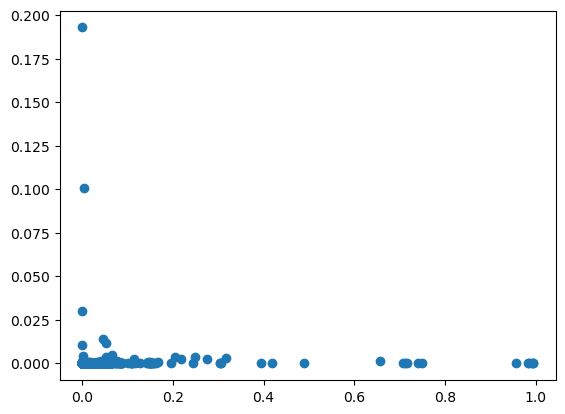

In [66]:
plt.scatter(gnom_filtered.AF_hom, gnom_filtered.AF_het)

<Axes: >

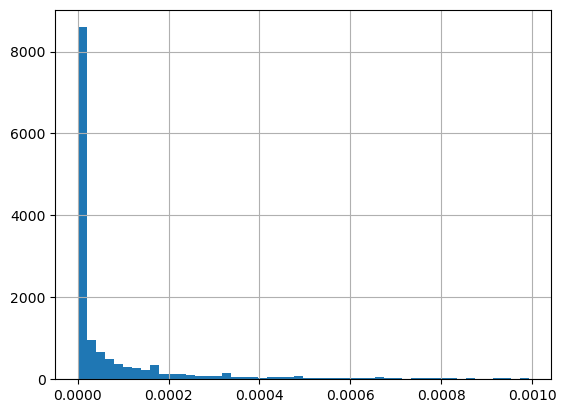

In [75]:
gnom_filtered.AF_hom[gnom_filtered.AF_hom.between(0, 0.001)].hist(bins=50)

In [77]:
# gnom_filtered[gnom_filtered['AF_hom'] < 0.0002]

### Take only AF_het

<Axes: >

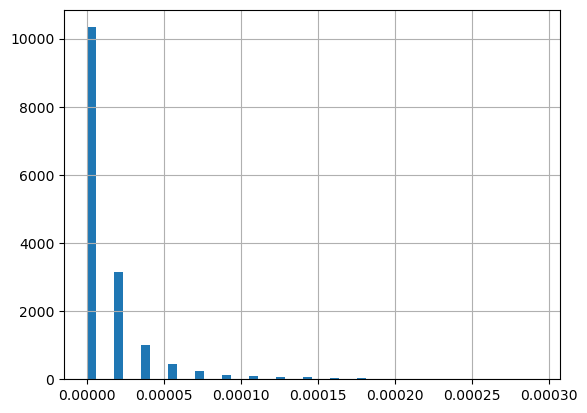

In [121]:
gnom_filtered.AF_het[gnom_filtered.AF_het.between(0, 0.0003)].hist(bins=50)

In [122]:
# gnom_filtered[gnom_filtered['AF_het'] < 0.0001]

### Collect datasets for next analysis

In [124]:
df_15_col_gnom = collect_mut_cancer(df_cancers=gnom_filtered, df_win=data_15_col, regime='2col')

In [125]:
df_loops_gnom = collect_mut_cancer(df_cancers=gnom_filtered, df_win=data_loops, regime='1col')

In [126]:
df_tetrads_gnom = collect_mut_cancer(df_cancers=gnom_filtered, df_win=data_tetrads, regime='1col')

In [127]:
df_category_gnom = collect_mut_cancer(gnom_filtered, df_category, regime='pos')

In [128]:
# df_loops_gnom.to_csv('../data/processed/df_loops_gnom_pqs.csv', index=False)
# df_15_col_gnom.to_csv('../data/processed/df_15_col_gnom_pqs.csv', index=False)
# df_tetrads_gnom.to_csv('../data/processed/df_tetrads_gnom_pqs.csv', index=False)
# df_category_gnom.to_csv('../data/processed/df_category_gnom_pqs.csv', index=False)

In [131]:
df_15_col_gnom_af_hom = collect_mut_cancer(df_cancers=gnom_filtered[gnom_filtered['AF_hom'] < 0.0002], df_win=data_15_col, regime='2col')
df_loops_gnom_af_hom = collect_mut_cancer(df_cancers=gnom_filtered[gnom_filtered['AF_hom'] < 0.0002], df_win=data_loops, regime='1col')
df_tetrads_gnom_af_hom = collect_mut_cancer(df_cancers=gnom_filtered[gnom_filtered['AF_hom'] < 0.0002], df_win=data_tetrads, regime='1col')
df_category_gnom_af_hom = collect_mut_cancer(gnom_filtered[gnom_filtered['AF_hom'] < 0.0002], df_category, regime='pos')

In [133]:
# df_loops_gnom_af_hom.to_csv('../data/processed/df_loops_gnom_af_hom_pqs.csv', index=False)
# df_15_col_gnom_af_hom.to_csv('../data/processed/df_15_col_gnom_af_hom_pqs.csv', index=False)
# df_tetrads_gnom_af_hom.to_csv('../data/processed/df_tetrads_gnom_af_hom_pqs.csv', index=False)
# df_category_gnom_af_hom.to_csv('../data/processed/df_category_gnom_af_hom_pqs.csv', index=False)

#### AF_het < 0.0001

In [105]:
df_15_col_gnom_af_het = collect_mut_cancer(df_cancers=gnom_filtered[gnom_filtered['AF_het'] < 0.0001], df_win=data_15_col, regime='2col')
df_loops_gnom_af_het = collect_mut_cancer(df_cancers=gnom_filtered[gnom_filtered['AF_het'] < 0.0001], df_win=data_loops, regime='1col')
df_tetrads_gnom_af_het = collect_mut_cancer(df_cancers=gnom_filtered[gnom_filtered['AF_het'] < 0.0001], df_win=data_tetrads, regime='1col')
df_category_gnom_af_het = collect_mut_cancer(gnom_filtered[gnom_filtered['AF_het'] < 0.0001], df_category, regime='pos')

In [108]:
# df_loops_gnom_af_het.to_csv('../data/processed/df_loops_gnom_af_het_pqs.csv', index=False)
# df_15_col_gnom_af_het.to_csv('../data/processed/df_15_col_gnom_af_het_pqs.csv', index=False)
# df_tetrads_gnom_af_het.to_csv('../data/processed/df_tetrads_gnom_af_het_pqs.csv', index=False)
# df_category_gnom_af_het.to_csv('../data/processed/df_category_gnom_af_het_pqs.csv', index=False)

### Prepare for count common mutspec

In [114]:
gnom_filtered = gnom_filtered.merge(ref_annot[['Pos', 'Type']], how='left', on='Pos')

#### **Without D_loop**

In [127]:
mut_gnom_wd_loop = pd.DataFrame(gnom_filtered[(~(gnom_filtered['Type'] == 'D-loop')) & (gnom_filtered['AF_het'] < 0.0001)] \
                                    .Mut.str.findall("[A-T]>[A-T]") \
                                    .value_counts()) \
                                    .sort_index().reset_index()

In [128]:
mut_gnom_wd_loop['expMut'] = ref_annot[~(ref_annot['Type'] == 'D-loop')].Nuc.value_counts() \
                                                                                .sort_index() \
                                                                                .repeat(3) \
                                                                                .reset_index(drop=True)

In [129]:
mut_gnom_wd_loop['MutSpec'] = mut_gnom_wd_loop['count']/mut_gnom_wd_loop['expMut']

In [130]:
mut_gnom_wd_loop["MutSpec"] = mut_gnom_wd_loop["MutSpec"] / mut_gnom_wd_loop["MutSpec"].sum()

In [131]:
mut_gnom_wd_loop

,Mut,count,expMut,MutSpec
0,[A>C],537,4785,0.029744
1,[A>G],3338,4785,0.184891
2,[A>T],517,4785,0.028636
3,[C>A],706,4810,0.038902
4,[C>G],150,4810,0.008265
5,[C>T],3073,4810,0.169328
6,[G>A],1646,2017,0.216289
7,[G>C],360,2017,0.047305
8,[G>T],113,2017,0.014849
9,[T>A],306,3834,0.021153


In [132]:
mutSpecs_gnom_wd_loop = []
for i in np.array_split(mut_gnom_wd_loop.MutSpec, 4):
    mutSpecs_gnom_wd_loop.append(i.sum())

C:\Users\777\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


In [133]:
# A C G T
mutSpecs_gnom_wd_loop

[0.24327154864734377,
 0.2164950061125338,
 0.27844279785621256,
 0.2617906473839097]

#### **D-loop**

In [169]:
mut_gnom_d_loop = pd.DataFrame(gnom_filtered[(gnom_filtered['Type'] == 'D-loop') & (gnom_filtered['AF_het'] < 0.0001)] \
                                    .Mut.str.findall("[A-T]>[A-T]") \
                                    .value_counts()) \
                                    .sort_index().reset_index()

In [170]:
mut_gnom_d_loop['expMut'] = ref_annot[(ref_annot['Type'] == 'D-loop')].Nuc.value_counts() \
                                                                                .sort_index() \
                                                                                .repeat(3) \
                                                                                .reset_index(drop=True)

In [171]:
mut_gnom_d_loop['MutSpec'] = mut_gnom_d_loop['count']/mut_gnom_d_loop['expMut']

In [172]:
mut_gnom_d_loop["MutSpec"] = mut_gnom_d_loop["MutSpec"] / mut_gnom_d_loop["MutSpec"].sum()

In [173]:
mut_gnom_d_loop

,Mut,count,expMut,MutSpec
0,[A>C],109,339,0.083373
1,[A>G],179,339,0.136915
2,[A>T],75,339,0.057367
3,[C>A],92,371,0.064300
4,[C>G],52,371,0.036344
5,[C>T],185,371,0.129299
6,[G>A],88,152,0.150119
7,[G>C],29,152,0.049471
8,[G>T],29,152,0.049471
9,[T>A],52,260,0.051859


In [174]:
mutSpecs_gnom_d_loop = []
for i in np.array_split(mut_gnom_d_loop.MutSpec, 4):
    mutSpecs_gnom_d_loop.append(i.sum())

C:\Users\777\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


In [175]:
# A C G T
mutSpecs_gnom_d_loop

[0.27765464680177154,
 0.22994290178765142,
 0.2490618944614847,
 0.24334055694909235]

# Helix mt pqs

In [65]:
helix = pd.read_table('../data/raw/HelixMTdb_20200327.tsv')

In [66]:
helix.shape

(14324, 12)

In [67]:
helix

,locus,alleles,feature,gene,counts_hom,AF_hom,counts_het,AF_het,mean_ARF,max_ARF,haplogroups_for_homoplasmic_variants,haplogroups_for_heteroplasmic_variants
0,chrM:5,"[""A"",""C""]",non_coding,MT-CRb,1,0.000005,0,0.000000,NaN,NaN,"[[""H"",1]]",[]
1,chrM:10,"[""T"",""C""]",non_coding,MT-CRb,7,0.000036,1,0.000005,0.91892,0.91892,"[[""H"",7]]","[[""H"",1]]"
2,chrM:11,"[""C"",""T""]",non_coding,MT-CRb,0,0.000000,1,0.000005,0.60714,0.60714,[],"[[""H"",1]]"
3,chrM:12,"[""T"",""C""]",non_coding,MT-CRb,1,0.000005,0,0.000000,NaN,NaN,"[[""D"",1]]",[]
4,chrM:16,"[""A"",""T""]",non_coding,MT-CRb,273,0.001393,4,0.000020,0.68971,0.92188,"[[""K"",246],[""U"",12],[""H"",7],[""V"",2],[""B"",1],[""...","[[""K"",2],[""L3"",1],[""U"",1]]"
...,...,...,...,...,...,...,...,...,...,...,...,...
14319,chrM:16558,"[""G"",""A""]",non_coding,MT-CR,3,0.000015,0,0.000000,NaN,NaN,"[[""J"",3]]",[]
14320,chrM:16559,"[""A"",""G""]",non_coding,MT-CR,9,0.000046,0,0.000000,NaN,NaN,"[[""A"",3],[""K"",3],[""H"",2],[""B"",1]]",[]
14321,chrM:16562,"[""T"",""C""]",non_coding,MT-CR,0,0.000000,1,0.000005,0.85714,0.85714,[],"[[""U"",1]]"
14322,chrM:16564,"[""A"",""G""]",non_coding,MT-CR,0,0.000000,1,0.000005,0.70000,0.70000,[],"[[""H"",1]]"


In [68]:
helix['Pos'] = helix.locus.str.extract('(\d+)')

In [69]:
helix['Pos'] = helix['Pos'].astype('int')

In [70]:
# helix['alleles'].str.findall('[A-T]').apply(lambda x:len(x) == 3)

In [71]:
helix['Mut'] = helix['alleles'].str.findall('[A-T]').apply(lambda x: '>'.join(x))

In [72]:
helix_filtered = helix[helix['Mut'].apply(lambda x:len(x) == 3)]

<Axes: >

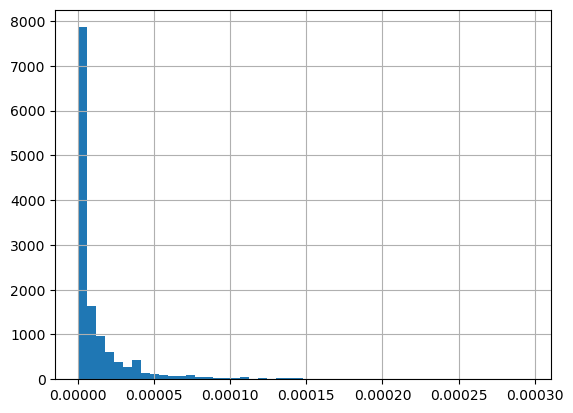

In [73]:
helix_filtered.AF_het[helix_filtered.AF_het.between(0, 0.0003)].hist(bins=50)

In [28]:
helix_filtered

,locus,alleles,feature,gene,counts_hom,AF_hom,counts_het,AF_het,mean_ARF,max_ARF,haplogroups_for_homoplasmic_variants,haplogroups_for_heteroplasmic_variants,Pos,Mut
0,chrM:5,"[""A"",""C""]",non_coding,MT-CRb,1,0.000005,0,0.000000,NaN,NaN,"[[""H"",1]]",[],5,A>C
1,chrM:10,"[""T"",""C""]",non_coding,MT-CRb,7,0.000036,1,0.000005,0.91892,0.91892,"[[""H"",7]]","[[""H"",1]]",10,T>C
2,chrM:11,"[""C"",""T""]",non_coding,MT-CRb,0,0.000000,1,0.000005,0.60714,0.60714,[],"[[""H"",1]]",11,C>T
3,chrM:12,"[""T"",""C""]",non_coding,MT-CRb,1,0.000005,0,0.000000,NaN,NaN,"[[""D"",1]]",[],12,T>C
4,chrM:16,"[""A"",""T""]",non_coding,MT-CRb,273,0.001393,4,0.000020,0.68971,0.92188,"[[""K"",246],[""U"",12],[""H"",7],[""V"",2],[""B"",1],[""...","[[""K"",2],[""L3"",1],[""U"",1]]",16,A>T
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14319,chrM:16558,"[""G"",""A""]",non_coding,MT-CR,3,0.000015,0,0.000000,NaN,NaN,"[[""J"",3]]",[],16558,G>A
14320,chrM:16559,"[""A"",""G""]",non_coding,MT-CR,9,0.000046,0,0.000000,NaN,NaN,"[[""A"",3],[""K"",3],[""H"",2],[""B"",1]]",[],16559,A>G
14321,chrM:16562,"[""T"",""C""]",non_coding,MT-CR,0,0.000000,1,0.000005,0.85714,0.85714,[],"[[""U"",1]]",16562,T>C
14322,chrM:16564,"[""A"",""G""]",non_coding,MT-CR,0,0.000000,1,0.000005,0.70000,0.70000,[],"[[""H"",1]]",16564,A>G


In [103]:
df_15_col_helix_af_het = collect_mut_cancer(df_cancers=helix_filtered[helix_filtered['AF_het'] < 0.00005], df_win=data_15_col, regime='2col')
df_loops_helix_af_het = collect_mut_cancer(df_cancers=helix_filtered[helix_filtered['AF_het'] < 0.00005], df_win=data_loops, regime='1col')
df_tetrads_helix_af_het = collect_mut_cancer(df_cancers=helix_filtered[helix_filtered['AF_het'] < 0.00005], df_win=data_tetrads, regime='1col')
df_category_helix_af_het = collect_mut_cancer(helix_filtered[helix_filtered['AF_het'] < 0.00005], df_category, regime='pos')

In [107]:
# df_loops_helix_af_het.to_csv('../data/processed/df_loops_helix_af_het_pqs.csv', index=False)
# df_15_col_helix_af_het.to_csv('../data/processed/df_15_col_helix_af_het_pqs.csv', index=False)
# df_tetrads_helix_af_het.to_csv('../data/processed/df_tetrads_helix_af_het_pqs.csv', index=False)
# df_category_helix_af_het.to_csv('../data/processed/df_category_helix_af_het_pqs.csv', index=False)

### Prepare for count common mutspec

#### **Without D_loop**

In [ ]:
helix_filtered

In [151]:
mut_helix_wd_loop = pd.DataFrame(helix_filtered[((helix_filtered['gene'] != 'MT-CRb') | (helix_filtered['gene'] != 'MT-CR')) & (helix_filtered['AF_het'] < 0.00005)] \
                                    .Mut.str.findall("[A-T]>[A-T]") \
                                    .value_counts()) \
                                    .sort_index().reset_index()

In [152]:
mut_helix_wd_loop['expMut'] = ref_annot[~(ref_annot['Type'] == 'D-loop')].Nuc.value_counts() \
                                                                                .sort_index() \
                                                                                .repeat(3) \
                                                                                .reset_index(drop=True)

In [153]:
mut_helix_wd_loop['MutSpec'] = mut_helix_wd_loop['count']/mut_helix_wd_loop['expMut']

In [154]:
mut_helix_wd_loop["MutSpec"] = mut_helix_wd_loop["MutSpec"] / mut_helix_wd_loop["MutSpec"].sum()

In [155]:
mut_helix_wd_loop

,Mut,count,expMut,MutSpec
0,[A>C],535,4785,0.036831
1,[A>G],2993,4785,0.206046
2,[A>T],723,4785,0.049773
3,[C>A],967,4810,0.066225
4,[C>G],283,4810,0.019381
5,[C>T],3079,4810,0.210865
6,[G>A],769,2017,0.125591
7,[G>C],257,2017,0.041973
8,[G>T],152,2017,0.024824
9,[T>A],338,3834,0.029040


In [156]:
mutSpecs_helix_wd_loop = []
for i in np.array_split(mut_helix_wd_loop.MutSpec, 4):
    mutSpecs_helix_wd_loop.append(i.sum())

C:\Users\777\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


In [157]:
# A C G T
mutSpecs_helix_wd_loop

[0.29264995816473227,
 0.2964707233207291,
 0.19238831712213897,
 0.21849100139239963]

#### **D_loop**

In [158]:
mut_helix_d_loop = pd.DataFrame(helix_filtered[((helix_filtered['gene'] == 'MT-CRb') | (helix_filtered['gene'] == 'MT-CR')) & (helix_filtered['AF_het'] < 0.00005)] \
                                    .Mut.str.findall("[A-T]>[A-T]") \
                                    .value_counts()) \
                                    .sort_index().reset_index()

In [163]:
mut_helix_d_loop['expMut'] = ref_annot[(ref_annot['Type'] == 'D-loop')].Nuc.value_counts() \
                                                                                .sort_index() \
                                                                                .repeat(3) \
                                                                                .reset_index(drop=True)

In [164]:
mut_helix_d_loop['MutSpec'] = mut_helix_d_loop['count']/mut_helix_d_loop['expMut']

In [165]:
mut_helix_d_loop["MutSpec"] = mut_helix_d_loop["MutSpec"] / mut_helix_d_loop["MutSpec"].sum()

In [166]:
mut_helix_d_loop

,Mut,count,expMut,MutSpec
0,[A>C],87,339,0.071099
1,[A>G],150,339,0.122585
2,[A>T],89,339,0.072734
3,[C>A],105,371,0.078408
4,[C>G],63,371,0.047045
5,[C>T],175,371,0.130680
6,[G>A],79,152,0.143989
7,[G>C],27,152,0.049211
8,[G>T],25,152,0.045566
9,[T>A],52,260,0.055408


In [167]:
mutSpecs_helix_d_loop = []
for i in np.array_split(mut_helix_d_loop.MutSpec, 4):
    mutSpecs_helix_d_loop.append(i.sum())

C:\Users\777\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


In [168]:
# A C G T
mutSpecs_helix_d_loop

[0.26641798667287353,
 0.25613318535843865,
 0.23876647501928563,
 0.23868235294940218]

# OTHER

## Location of g4

In [58]:
g4_location = []
for G4_id, start, end in zip(g4conf['G4_id'], g4conf['start'], g4conf['end']):
    location = []
    row = []
    for i in range(start, end+1):
        # row.append(G4_id)
        # row.append(i)
        location.append(ref_annot[ref_annot['Pos'] == i]['Type'].to_string(index=False))
        
    row.append(G4_id)
    row.append('/'.join(list(set(location))))
    g4_location.append(row)

In [59]:
g4_location

[[1, 'D-loop'],
 [2, 'D-loop'],
 [3, 'D-loop/tRNA'],
 [4, 'rRNA'],
 [5, 'rRNA'],
 [6, 'tRNA/rRNA'],
 [7, 'rRNA'],
 [8, 'rRNA'],
 [9, 'rRNA'],
 [10, 'rRNA'],
 [11, 'CDS'],
 [12, 'CDS'],
 [13, 'CDS'],
 [14, 'CDS'],
 [15, 'CDS'],
 [16, 'CDS'],
 [17, 'tRNA'],
 [18, 'tRNA/CDS'],
 [19, 'CDS'],
 [20, 'CDS'],
 [21, 'CDS'],
 [22, 'CDS'],
 [23, 'CDS'],
 [24, 'tRNA/NaN/CDS'],
 [25, 'CDS'],
 [26, 'CDS'],
 [27, 'CDS'],
 [28, 'CDS'],
 [29, 'CDS'],
 [30, 'CDS'],
 [31, 'CDS'],
 [32, 'NaN/CDS/tRNA'],
 [33, 'CDS'],
 [34, 'CDS'],
 [35, 'CDS'],
 [36, 'CDS'],
 [37, 'CDS'],
 [38, 'CDS'],
 [39, 'CDS'],
 [40, 'CDS'],
 [41, 'CDS'],
 [42, 'CDS'],
 [43, 'CDS'],
 [44, 'CDS'],
 [45, 'CDS'],
 [46, 'CDS'],
 [47, 'CDS'],
 [48, 'CDS'],
 [49, 'CDS'],
 [50, 'CDS'],
 [51, 'CDS'],
 [52, 'CDS'],
 [53, 'CDS'],
 [54, 'CDS'],
 [55, 'CDS'],
 [56, 'CDS'],
 [57, 'CDS'],
 [58, 'CDS'],
 [59, 'CDS'],
 [60, 'CDS'],
 [61, 'CDS'],
 [62, 'CDS'],
 [63, 'CDS'],
 [64, 'CDS'],
 [65, 'CDS'],
 [66, 'CDS'],
 [67, 'CDS'],
 [68, 'CDS'],
 [69, '

In [60]:
df_g4_location = pd.DataFrame(data=g4_location, columns=['G4_id', 'location'])

In [61]:
df_g4_location

,G4_id,location
0,1,D-loop
1,2,D-loop
2,3,D-loop/tRNA
3,4,rRNA
4,5,rRNA
...,...,...
69,70,CDS
70,71,D-loop
71,72,D-loop
72,73,D-loop


In [65]:
df_g4_location = df_g4_location.set_index('G4_id')['location'].str.split('/', expand=True) \
    .stack() \
    .reset_index(name='location') \
    .drop('level_1', axis=1)

In [66]:
df_g4_location

,G4_id,location
0,1,D-loop
1,2,D-loop
2,3,D-loop
3,3,tRNA
4,4,rRNA
...,...,...
76,70,CDS
77,71,D-loop
78,72,D-loop
79,73,D-loop


In [64]:
# df_g4_location.to_csv('../data/processed/df_g4_location.csv', index=False)

In [7]:
g4conf.columns

Index(['seqnames', 'start', 'end', 'width', 'strand', 'score', 'max_score',
       'threshold', 'window', 'sequence', 'confirmed', 'G4', 'note',
       'start-100bp', 'end+100bp', 'start-50bp', 'end+50bp',
       'bp_untill_next_G4', 'bp_untill_previous_G4', 'G4_id', 'up_win',
       'down_win'],
      dtype='object')

In [13]:
df_g4_type = g4conf[['G4_id', 'G4']].rename(columns={'G4':'Type_of_G4'})

In [17]:
# df_g4_type.to_csv('../data/processed/df_g4_type.csv', index=False)

## G4 location *in vivo* (doi.org/10.1093/nar/gkad535)

In [34]:
G4_peaks = [[1, 2425, 3986], [2, 4330, 4624], [3, 5570, 7168], [4, 7139, 7559], [5, 7800, 8276], [6, 8958, 9869], [7, 12762, 13771]]

In [41]:
df_g4_vivo_peaks = pd.DataFrame(G4_peaks, columns=['number', 'start', 'end'])

In [42]:
df_g4_vivo_peaks

,number,start,end
0,1,2425,3986
1,2,4330,4624
2,3,5570,7168
3,4,7139,7559
4,5,7800,8276
5,6,8958,9869
6,7,12762,13771


In [57]:
# g4conf

In [52]:
g4_vivo = []
for start, end, G4_id in zip(g4conf['start'], g4conf['end'], g4conf['G4_id']):
    for p_start, p_end, number in zip(df_g4_vivo_peaks['start'], df_g4_vivo_peaks['end'], df_g4_vivo_peaks['number']):
        row = []
        if start in range(p_start, p_end) or end in range(p_start, p_end):
            row.append(number)
            row.append(G4_id)
            row.append(1)
            g4_vivo.append(row)

In [53]:
df_g4_vivo = pd.DataFrame(g4_vivo, columns=['peak_number', 'G4_id', 'in_vivo'])

In [54]:
df_g4_vivo

,peak_number,G4_id,in_vivo
0,1,9,1
1,1,10,1
2,1,11,1
3,1,12,1
4,1,13,1
5,2,17,1
6,2,18,1
7,3,24,1
8,3,25,1
9,3,26,1


In [56]:
# df_g4_vivo.to_csv('../data/processed/df_g4_vivo.csv', index=False)

## Check decrease of С>T  
Make new windows which cover all length G4 and +-25 bp 


In [7]:
g4conf

,seqnames,start,end,width,strand,score,max_score,threshold,window,sequence,...,note,start-100bp,end+100bp,start-50bp,end+50bp,bp_untill_next_G4,bp_untill_previous_G4,G4_id,up_win,down_win
0,"NC_012920.1 Homo sapiens mitochondrion, comple...",285,332,48,-,-1.250,-2.24,1,25,CAAAAAATTTCCACCAAACCCCCCCTCCCCCGCTTCTGGCCACAGCAC,...,more than africa,185,432,235,382,16,294,1,185,348
1,"NC_012920.1 Homo sapiens mitochondrion, comple...",348,378,31,-,-1.100,-1.16,1,25,CCAAACCCCAAAAACAAAGAACCCTAACACC,...,less than africa,248,478,298,428,40,16,2,332,418
2,"NC_012920.1 Homo sapiens mitochondrion, comple...",418,592,175,-,-1.150,-1.88,1,25,CACTTTTAACAGTCACCCCCCAACTAACACATTATTTTCCCCTCCC...,...,5 overlapping g4 in africa,318,692,368,642,193,40,3,378,692
3,"NC_012920.1 Homo sapiens mitochondrion, comple...",785,808,24,-,-1.210,-1.16,1,25,CGCTTAGCCTAGCCACACCCCCAC,...,NaN,685,908,735,858,146,193,4,685,908
4,"NC_012920.1 Homo sapiens mitochondrion, comple...",954,984,31,-,-1.390,-1.48,1,25,CACCCCCTCCCCAATAAAGCTAAAACTCACC,...,NaN,854,1084,904,1034,683,146,5,854,1084
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,"NC_012920.1 Homo sapiens mitochondrion, comple...",15636,15683,48,-,-0.896,-1.16,1,25,CCATCCTCATCCTAGCAATAATCCCCATCCTCCATATATCCAAACAAC,...,more than africa,15536,15783,15586,15733,484,80,70,15556,15783
70,"NC_012920.1 Homo sapiens mitochondrion, comple...",16167,16211,45,-,-1.160,-1.80,1,25,CCCAATCCACATCAAAACCCCCTCCCCATGCTTACAAGCAAGTAC,...,more than africa,16067,16311,16117,16261,28,484,71,16067,16239
71,"NC_012920.1 Homo sapiens mitochondrion, comple...",16239,16301,63,-,-0.968,-1.40,1,25,CAACTGCAACTCCAAAGCCACCCCTCACCCACTAGGATACCAACAA...,...,more than africa,16139,16401,16189,16351,43,28,72,16211,16344
72,"NC_012920.1 Homo sapiens mitochondrion, comple...",16344,16382,39,-,-1.210,-1.48,1,25,CAGTCAAATCCCTTCTCGTCCCCATGGATGACCCCCCTC,...,more than africa,16244,16482,16294,16432,145,43,73,16301,16482


In [6]:
df_25bp = g4conf[(g4conf['bp_untill_previous_G4'] >= 25) & 
            (g4conf['bp_untill_next_G4'] >= 25) & 
            (g4conf['end'] + 25 <= 16569)]

In [7]:
df_25bp

,seqnames,start,end,width,strand,score,max_score,threshold,window,sequence,...,note,start-100bp,end+100bp,start-50bp,end+50bp,bp_untill_next_G4,bp_untill_previous_G4,G4_id,up_win,down_win
2,"NC_012920.1 Homo sapiens mitochondrion, comple...",418,592,175,-,-1.150,-1.88,1,25,CACTTTTAACAGTCACCCCCCAACTAACACATTATTTTCCCCTCCC...,...,5 overlapping g4 in africa,318,692,368,642,193,40,3,378,692
3,"NC_012920.1 Homo sapiens mitochondrion, comple...",785,808,24,-,-1.210,-1.16,1,25,CGCTTAGCCTAGCCACACCCCCAC,...,NaN,685,908,735,858,146,193,4,685,908
4,"NC_012920.1 Homo sapiens mitochondrion, comple...",954,984,31,-,-1.390,-1.48,1,25,CACCCCCTCCCCAATAAAGCTAAAACTCACC,...,NaN,854,1084,904,1034,683,146,5,854,1084
5,"NC_012920.1 Homo sapiens mitochondrion, comple...",1667,1707,41,-,-1.020,-1.48,1,25,CTGAGCTAAACCTAGCCCCAAACCCACTCCACCTTACTACC,...,more than in africa,1567,1807,1617,1757,350,683,6,1567,1807
6,"NC_012920.1 Homo sapiens mitochondrion, comple...",2057,2079,23,-,-1.520,-1.40,1,25,CCCACAGAACCCTCTAAATCCCC,...,NaN,1957,2179,2007,2129,133,350,7,1957,2179
7,"NC_012920.1 Homo sapiens mitochondrion, comple...",2212,2236,25,-,-1.000,-1.00,1,25,CAACACCCACTACCTAAAAAATCCC,...,NaN,2112,2336,2162,2286,912,133,8,2112,2336
10,"NC_012920.1 Homo sapiens mitochondrion, comple...",3471,3604,134,-,-1.170,-2.76,1,25,CTTCACCAAAGAGCCCCTAAAACCCGCCACATCTACCATCACCCTC...,...,5 overlapping g4 in africa,3371,3704,3421,3654,270,249,11,3371,3704
11,"NC_012920.1 Homo sapiens mitochondrion, comple...",3874,3909,36,-,-0.917,-1.28,1,25,CTAGCAGAGACCAACCGAACCCCCTTCGACCTTGCC,...,NaN,3774,4009,3824,3959,42,270,12,3774,3951
12,"NC_012920.1 Homo sapiens mitochondrion, comple...",3951,3984,34,-,-0.882,-1.20,1,25,CGCCGCAGGCCCCTTCGCCCTATTCTTCATAGCC,...,more than africa,3851,4084,3901,4034,102,42,13,3909,4084
15,"NC_012920.1 Homo sapiens mitochondrion, comple...",4228,4260,33,-,-1.210,-1.28,1,25,CCCATTACAATCTCCAGCATTCCCCCTCAAACC,...,NaN,4128,4360,4178,4310,112,67,16,4161,4360


In [58]:
# df_25bp['start'] = df_25bp['start'].apply(lambda x: x-25)
# df_25bp['end'] = df_25bp['end'].apply(lambda x: x+25)

In [10]:
data_check_start = []

for start, end, G4_id in zip(df_25bp['start'], 
                             df_25bp['end'], 
                             df_25bp['G4_id']):
    
    number_of_win = 0
    
    for i in range(start-25, end+25):
        row = []
        
        if i+WINDOW_SIZE <= end+25:
            window = [*range(i, i + WINDOW_SIZE)]       
        else:
            break

        window_seq = ''
        for pos in window:
            if pos != 3107:
                window_seq += str(ref_annot[ref_annot['Pos'] == pos].Nuc.values[0])
            else:
                window_seq += ''
        
        # print(i, window, WINDOW_SIZE, end)  
        
        number_of_win += 1

        row.append(G4_id)
        row.append('check_start')
        row.append(number_of_win)
        row.append(window[0])
        row.append(window[-1])
        row.append(window_seq)
        
        data_check_start.append(row)
# print(data_check_start)

In [15]:
data_check_end = []

for start, end, G4_id in zip(df_25bp['start'], 
                             df_25bp['end'], 
                             df_25bp['G4_id']):
    
    number_of_win = 0
    
    for i in range(end+25, start-25, -1):
        row = []

        
        if i+WINDOW_SIZE > end+25:
            continue  
        elif (i+WINDOW_SIZE <= end+25):
            window = [*range(i, i + WINDOW_SIZE)]       
        else:
            continue

        window_seq = ''
        for pos in window:
            if pos != 3107:
                window_seq += str(ref_annot[ref_annot['Pos'] == pos].Nuc.values[0])
            else:
                window_seq += ''
        
        number_of_win += 1

        row.append(G4_id)
        row.append('check_end')
        row.append(number_of_win)
        row.append(window[0])
        row.append(window[-1])
        row.append(window_seq)
        
        data_check_end.append(row)
# print(data_check_end)

In [16]:
data_check_sides = data_check_start + data_check_end

In [24]:
# data_check_sides

In [18]:
df_win_check_sides = pd.DataFrame(data=data_check_sides, 
                             columns = ['G4_id', 'side', 'number_of_win', 'window_start', 'window_end', 'sequence'])

In [23]:
df_win_check_sides[(df_win_check_sides['side'] == 'check_end') & (df_win_check_sides['G4_id'] == 3)]

,G4_id,side,number_of_win,window_start,window_end,sequence
4901,3,check_end,1,607,616,CACTGAAAAT
4902,3,check_end,2,606,615,ACACTGAAAA
4903,3,check_end,3,605,614,TACACTGAAA
4904,3,check_end,4,604,613,ATACACTGAA
4905,3,check_end,5,603,612,AATACACTGA
...,...,...,...,...,...,...
5110,3,check_end,210,398,407,TTTTATCTTT
5111,3,check_end,211,397,406,ATTTTATCTT
5112,3,check_end,212,396,405,AATTTTATCT
5113,3,check_end,213,395,404,AAATTTTATC


In [25]:
nuc_count_win_check_sides = df_win_check_sides['sequence'].apply(lambda x: Counter(x))

In [26]:
nuc_count_df_win_check_sides = pd.DataFrame.from_records(nuc_count_win_check_sides).sort_index(axis=1)

In [27]:
df_win_check_sides = df_win_check_sides.join(nuc_count_df_win_check_sides).fillna(0)

In [28]:
df_win_check_sides

,G4_id,side,number_of_win,window_start,window_end,sequence,A,C,G,T
0,3,check_start,1,393,402,TCAAATTTTA,4.0,1.0,0.0,5.0
1,3,check_start,2,394,403,CAAATTTTAT,4.0,1.0,0.0,5.0
2,3,check_start,3,395,404,AAATTTTATC,4.0,1.0,0.0,5.0
3,3,check_start,4,396,405,AATTTTATCT,3.0,1.0,0.0,6.0
4,3,check_start,5,397,406,ATTTTATCTT,2.0,1.0,0.0,7.0
...,...,...,...,...,...,...,...,...,...,...
9743,73,check_end,74,16324,16333,TTACCGTACA,3.0,3.0,1.0,3.0
9744,73,check_end,75,16323,16332,TTTACCGTAC,2.0,3.0,1.0,4.0
9745,73,check_end,76,16322,16331,ATTTACCGTA,3.0,2.0,1.0,4.0
9746,73,check_end,77,16321,16330,CATTTACCGT,2.0,3.0,1.0,4.0


In [30]:
# df_win_check_sides.to_csv('../data/processed/df_win_check_sides.csv', index=False)

Collect mutations from cancer dataset

In [32]:
df_cancers = pd.read_csv('../data/raw/mutations.csv')

In [33]:
df_win_check_sides = pd.read_csv('../data/processed/df_win_check_sides.csv')

In [39]:
Mut_win_check_sides = []
for window_start, window_end in zip(df_win_check_sides['window_start'], df_win_check_sides['window_end']):
    row = [*range(window_start, window_end)]
    Mut_win_check_sides.append(str(df_cancers[df_cancers['Pos'].isin(row)].Mut.values))

In [40]:
Mut_win_df_check_sides = pd.DataFrame(Mut_win_check_sides)

In [41]:
Mut_win_df_check_sides[0] = Mut_win_df_check_sides[0].str.findall("[A-T]>[A-T]")

In [42]:
obsMutwin_check_sides = pd.DataFrame.from_records(Mut_win_df_check_sides[0].apply(lambda x: Counter(x))) \
    .fillna(0) \
    .sort_index(axis=1)

In [43]:
df_win_cancer_check_sides = df_win_check_sides.join(obsMutwin_check_sides)

In [44]:
df_win_cancer_check_sides['number_of_Mut'] = df_win_cancer_check_sides[['A>C','A>G','A>T',
                                                              'C>A','C>G','C>T',
                                                              'G>A','G>C','G>T',
                                                              'T>A','T>C','T>G']].sum(axis=1)

In [45]:
df_win_cancer_check_sides.head()

,G4_id,side,number_of_win,window_start,window_end,sequence,A,C,G,T,...,C>A,C>G,C>T,G>A,G>C,G>T,T>A,T>C,T>G,number_of_Mut
0,3,check_start,1,393,402,TCAAATTTTA,4.0,1.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3,check_start,2,394,403,CAAATTTTAT,4.0,1.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,check_start,3,395,404,AAATTTTATC,4.0,1.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,3,check_start,4,396,405,AATTTTATCT,3.0,1.0,0.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,3,check_start,5,397,406,ATTTTATCTT,2.0,1.0,0.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [47]:
# df_win_cancer_check_sides.to_csv('../data/processed/df_win_cancer_check_sides.csv', index=False)